### Installing data

In [1]:
GPATH = "/content/drive/MyDrive/btp/datasets/"
DATASET = "/kaggle/input/highway-anomaly"
MODEL_PATH = GPATH + "model/"
file_name = "frame_avenue.zip"

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import smart_resize
import numpy as np
from tqdm import tqdm

import os
import pathlib
import time
from zipfile import ZipFile
import re
import datetime
from shutil import copyfile
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt
from IPython import display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def plot_digits(X, cmap, title="default images"):
    """Plots labels and MNIST digits as function of 2D latent vector

    cases
    (,)
    (4,)
    (2,2,) OK   
    """
    b = len(X)
    figure, axis = plt.subplots(1, b)
    for i in range(b):
      axis[i].imshow(X[i], cmap=cmap)
    plt.show()
    

In [4]:
! pip install yacs
! pip install natsort

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from yacs.config import CfgNode as CN


_C = CN()

_C.OUTPUT_DIR = 'output'
_C.LOG_DIR = 'log'
_C.GPUS = (0, 1, 2, 3)
_C.WORKERS = 2
_C.PRINT_FREQ = 50
_C.SAVE_CHECKPOINT_FREQ = 5
_C.AUTO_RESUME = False
_C.PIN_MEMORY = True

# Cudnn related params
_C.CUDNN = CN()
_C.CUDNN.BENCHMARK = True
_C.CUDNN.DETERMINISTIC = False
_C.CUDNN.ENABLED = True


# DATASET related params
_C.DATASET = CN()
_C.DATASET.ROOT = DATASET
_C.DATASET.DATASET = 'highway_anomaly'
_C.DATASET.TRAINSET = 'Train'
_C.DATASET.TESTSET = 'Test'
_C.DATASET.NUM_INCHANNELS = 3
_C.DATASET.NUM_FRAMES = 4
_C.DATASET.FRAME_STEPS = 1
_C.DATASET.LOWER_BOUND = 500


# train
_C.TRAIN = CN()

_C.TRAIN.BATCH_SIZE_PER_GPU = 1
_C.TRAIN.SHUFFLE = True

_C.TRAIN.BEGIN_EPOCH = 0
_C.TRAIN.END_EPOCH = 200
_C.TRAIN.RESUME = True
_C.TRAIN.CHECKPOINT = ''

_C.TRAIN.OPTIMIZER = 'adam'

# sgd and
_C.TRAIN.MOMENTUM = 0.0
_C.TRAIN.WD = 0.0
_C.TRAIN.NESTEROV = False

_C.TRAIN.LR_TYPE = 'linear'     # 'linear'  /   'step'  /   'multistep'
_C.TRAIN.LR = 0.0002
_C.TRAIN.LR_STEP = [40, 70]
_C.TRAIN.LR_FACTOR = 0.5


# testing
_C.TEST = CN()

# size of images for each device
_C.TEST.BATCH_SIZE_PER_GPU = 1


# common params for NETWORK
_C.MODEL = CN()
_C.MODEL.NAME = 'wrn38'
_C.MODEL.INIT_WEIGHTS = True
_C.MODEL.PRETRAINED = ''
_C.MODEL.IMAGE_SIZE = [160, 160]  # width * height
_C.MODEL.MEMORY_SIZE = 3
_C.MODEL.ENCODED_FRAMES = 1
_C.MODEL.DECODED_FRAMES = 0
# _C.MODEL.SIGMA = 1.5


_C.MODEL.EXTRA = CN()
_C.MODEL.EXTRA.FINAL_CONV_KERNEL = 1


def update_config(cfg, args):
    cfg.defrost()
    cfg.merge_from_file(args.cfg)
    cfg.merge_from_list(args.opts)
    cfg.freeze()


import sys
with open("conf1", 'w') as f:
    print(_C, file=f)
config = _C


### data preprocessing

In [6]:
import os
import glob
import logging
import time
import math
import pickle
from pickletools import uint8
import numpy as np
import scipy.io as scio
import natsort
from PIL import Image
import torchvision.transforms as transforms
import torch.utils.data as data
from pathlib import Path
from sklearn import metrics
from tensorflow.keras.preprocessing.image import smart_resize

In [7]:
class Label:
    def __init__(self, config):
        root = config.DATASET.ROOT
        dataset_name = config.DATASET.DATASET
        if dataset_name == 'shanghai':
            self.frame_mask = os.path.join(root, dataset_name, 'test_frame_mask/*')
        mat_name = dataset_name + '.mat'

        test_set = config.DATASET.TESTSET
        self.mat_path = os.path.join(root, dataset_name, test_set, mat_name)
        test_dataset_path = os.path.join(root, dataset_name, test_set)
        video_folders = (os.listdir(test_dataset_path))
        video_folders.sort()
        self.video_folders = [os.path.join(test_dataset_path, folder) for folder in video_folders]
        self.dataset_name = dataset_name

    def __call__(self):
        if self.dataset_name == 'shanghai':
            np_list = glob.glob(self.frame_mask)
            np_list.sort()

            gt = []
            for npy in np_list:
                gt.append(np.load(npy))

            return gt
        else:
            abnormal_mat = scio.loadmat(self.mat_path, struct_as_record=True, squeeze_me=True)['TestVideoFile']

            all_gt = []
            for i in range(abnormal_mat.shape[0]):
                length = len(os.listdir(self.video_folders[i]))
                sub_video_gt = np.zeros((length,), dtype=np.int8)

                one_abnormal = abnormal_mat[i]
                if one_abnormal.ndim == 2:
                    one_abnormal = one_abnormal.reshape((-1))

                j = 0
                while j < (one_abnormal.shape[0]):
                    start = one_abnormal[j] - 1   # TODO
                    end = one_abnormal[j+1]
                    j += 2
                    sub_video_gt[start: end] = 1

                all_gt.append(sub_video_gt)

            return all_gt


In [8]:
def make_power_2(n, base=32.0):
    return int(round(n / base) * base)


def get_transform(size, method=Image.BICUBIC, normalize=True, toTensor=True):
    w, h = size
    new_size = [make_power_2(w), make_power_2(h)]

    transform_list = [transforms.Resize(new_size, method)]

    if toTensor:
        transform_list += [transforms.ToTensor()]
    if normalize:
        transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)


class TestVideo(data.Dataset):
    def __init__(self, config, train=False):
        super(TestVideo, self).__init__()
        self.new_size = [config.MODEL.IMAGE_SIZE[0], config.MODEL.IMAGE_SIZE[1]]
        root = config.DATASET.ROOT
        dataset_name = config.DATASET.DATASET
        test_set = config.DATASET.TESTSET
        train_set = config.DATASET.TRAINSET
        if train == True:
          self.dir = os.path.join(root, dataset_name, train_set)
        else:
          self.dir = os.path.join(root, dataset_name, test_set)
        assert (os.path.exists(self.dir))

        self.videos = self._collect_filelist(self.dir)
        print(self.dir)

        self.num_videos = len(self.videos)

    def _collect_filelist(self, root):
        include_ext = [".png", ".jpg", "jpeg", ".tif"]
        # collect subfolders
        dirs = [x[0] for x in os.walk(root, followlinks=True)]  # if not x[0].startswith('.')]
        # sort both dirs and individual images
        dirs = natsort.natsorted(dirs)

        datasets = [
            [os.path.join(fdir, el) for el in natsort.natsorted(os.listdir(fdir))
             if os.path.isfile(os.path.join(fdir, el))
             and not el.startswith('.')
             and any([el.endswith(ext) for ext in include_ext])]

            for fdir in dirs
        ]

        return [el for el in datasets if el]

    def __len__(self):
        return self.num_videos

    def __getitem__(self, index):
        video_name = self.videos[index]

        video = []
        for name in video_name:
            video.append(name)

        return {'video': video, 'video_name': video_name}


In [9]:
def read_frame(name):
    transform = get_transform([config.MODEL.IMAGE_SIZE[0], config.MODEL.IMAGE_SIZE[1]])
    frame = Image.open(name).convert('RGB')
    frame = transform(frame)
    return frame

In [10]:
def create_logger(cfg, cfg_name, phase='train'):
    root_output_dir = Path(cfg.OUTPUT_DIR)
    # set up logger
    if not root_output_dir.exists():
        print('=> creating {}'.format(root_output_dir))
        root_output_dir.mkdir()

    dataset = cfg.DATASET.DATASET
    model = cfg.MODEL.NAME
    cfg_name = os.path.basename(cfg_name).split('.')[0]

    final_output_dir = root_output_dir / dataset / cfg_name

    print('=> creating {}'.format(final_output_dir))
    final_output_dir.mkdir(parents=True, exist_ok=True)

    time_str = time.strftime('%Y-%m-%d-%H-%M')
    log_file = '{}_{}_{}.log'.format(cfg_name, time_str, phase)
    final_log_file = final_output_dir / log_file
    head = '%(asctime)-15s %(message)s'
    logging.basicConfig(filename=str(final_log_file),
                        format=head)
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    console = logging.StreamHandler()
    logging.getLogger('').addHandler(console)

    tensorboard_log_dir = Path(cfg.LOG_DIR) / dataset / model / \
                          (cfg_name + '_' + time_str)
    print('=> creating {}'.format(tensorboard_log_dir))
    tensorboard_log_dir.mkdir(parents=True, exist_ok=True)

    return logger, str(final_output_dir), str(tensorboard_log_dir)


def psnr_park(mse):
    return 10 * math.log10(1 / mse)


def anomaly_score(psnr, max_psnr, min_psnr):
    return (psnr - min_psnr) / (max_psnr - min_psnr)


def calculate_auc(config, psnr_list, mat):
    ef = config.MODEL.ENCODED_FRAMES
    df = config.MODEL.DECODED_FRAMES
    fp = ef + df  # number of frames to process

    scores = np.array([], dtype=np.float)
    labels = np.array([], dtype=np.int)
    for i in range(len(psnr_list)):
        score = anomaly_score(psnr_list[i], np.max(psnr_list[i]), np.min(psnr_list[i]))
        scores = np.concatenate((scores, score), axis=0)
        labels = np.concatenate((labels, mat[i][fp:]), axis=0)
    assert scores.shape == labels.shape, f'Ground truth has {labels.shape[0]} frames, BUT got {scores.shape[0]} detected frames!'
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=0)
    auc = metrics.auc(fpr, tpr)

    return auc, fpr, tpr

def resize_img_ds(image):
  """Normalizes images: `uint8` -> `float32`."""
  shape1 = image.shape
  image = image.reshape(shape1[0], shape1[1], 1)
  size = (256, 256)
  return smart_resize(image, size).reshape(256, 256, 1)



In [11]:
logger = logging.getLogger(__name__)


def decode_input(input, train=True):
    video = input['video']
    video_name = input['video_name']

    if train:
        inputs = video[:-1]
        target = video[-1]
        return inputs, target
        # return video, video_name
    else:   # TODO: bo sung cho test
        return video, video_name

In [12]:
get_any_data = TestVideo
get_label = Label

In [13]:
mat_loader = get_label(config)
mat = mat_loader()

In [14]:
test_dataset = eval('get_any_data')(config, train=False)

/kaggle/input/highway-anomaly/highway_anomaly/Test


In [15]:
ls ../input/highway-anomaly/highway_anomaly/Test/

frames_001/  frames_004/  frames_007/  frames_010/
frames_002/  frames_005/  frames_008/  highway_anomaly.mat
frames_003/  frames_006/  frames_009/


In [16]:
test_loader = data.DataLoader(
    test_dataset,
    batch_size=config.TEST.BATCH_SIZE_PER_GPU * 1,
    shuffle=False,
    num_workers=config.WORKERS,
    pin_memory=True
)

In [17]:
test_dataset = eval('get_any_data')(config, train=True)

/kaggle/input/highway-anomaly/highway_anomaly/Train


In [18]:
train_loader = data.DataLoader(
    test_dataset,
    batch_size=config.TRAIN.BATCH_SIZE_PER_GPU * 1,
    shuffle=False,
    num_workers=config.WORKERS,
    pin_memory=True
)

### Model

In [19]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBnRelu(nn.Module):
    # https://github.com/lingtengqiu/Deeperlab-pytorch/blob/master/seg_opr/seg_oprs.py
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class ConvTransposeBnRelu(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride=2,padding = 0):
        super(ConvTransposeBnRelu, self).__init__()
        if stride != 2:     # ConvTranspose2d with factor = 4
            if kernel_size == 2 or kernel_size == 3:    # stride == 4
                padding = 1
                output_padding = 0
        else:       # ConvTranspose2d with factor = 2
            if kernel_size == 4:
                padding = 1
                output_padding = 0
            elif kernel_size == 3:
                padding = 1
                output_padding = 1
            elif kernel_size == 2:
                padding = 0
                output_padding = 0
        self.ConvTranspose = nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels,
                                                kernel_size=kernel_size, stride=stride, padding=padding,
                                                output_padding=output_padding, bias=False)
        self.bn = nn.BatchNorm2d(output_channels, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.ConvTranspose(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class ChannelAttention(nn.Module):
    def __init__(self, input_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.layer = nn.Sequential(
            nn.Conv2d(input_channels, input_channels//reduction, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(input_channels//reduction, input_channels, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.layer(y)
        return x * y


In [20]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        x1 = self.block1(out) # [216, 160, 160]
        out = self.trans1(x1)
        x2 = self.block2(out) #  [300, 80, 80]
        out = self.trans2(x2)
        out = self.block3(out) # [42, 40, 40]
        x3 = self.relu(self.bn1(out))
        return x3, x2, x1

In [21]:
import logging
import torch
import torch.nn as nn

logger = logging.getLogger(__name__)

class StemEncoder(nn.Module):
    def get_name(self):
        return self.model_name

    def __init__(self, config):
        super(StemEncoder, self).__init__()
        frames = 1
        
        self.DenseNet = DenseNet3(64, 10)
        
        channels = [216, 192, 144, 72, 27]

        self.conv_x3 = nn.Conv2d(channels[0] * frames, channels[1], kernel_size=1, bias=False)
        self.conv_x2 = nn.Conv2d(channels[1] * frames, channels[2], kernel_size=1, bias=False)
        self.conv_x1 = nn.Conv2d(channels[2] * frames, channels[3], kernel_size=1, bias=False)

        initialize_weights(self.conv_x1, self.conv_x2, self.conv_x3)

    def forward(self, x):
        x3, x2, x1 = self.DenseNet(x)
        x3 = self.conv_x3(x3)   # [216, 40, 40] --> 192
        x2 = self.conv_x2(x2)   # [192, 80, 80] --> 144
        x1 = self.conv_x1(x1)   # [144, 160, 160] --> 72
        
        # x1s, x2s, x8s = [], [], []
        # for xi in x:
        #     x8 = self.DenseNet(xi)
        #     x1s.append(x1)

        # x8 = self.conv_x8(torch.cat(x8s, dim=1))
        # x2 = self.conv_x2(torch.cat(x2s, dim=1))
        # x1 = self.conv_x1(torch.cat(x1s, dim=1))

        # left = self.tsm_left(x8)
        # x8 = x8 + left
        
        return x3, x2, x1

In [22]:
class StemDecoder(nn.Module):
    def __init__(self, config, bilinear=False):
        super(StemDecoder, self).__init__()
        channels = [216, 192, 144, 72, 54, 36]
        final_conv_kernel = config.MODEL.EXTRA.FINAL_CONV_KERNEL
        self.up3 = ConvTransposeBnRelu(channels[1], channels[2], kernel_size=2)   # 192 -> 144
        self.up2 = ConvTransposeBnRelu(channels[2] + channels[2], channels[3], kernel_size=2)   # 144  +  144 -> 72
        self.up1 = ConvTransposeBnRelu(channels[3] + channels[3], channels[4], kernel_size=3, padding=0, stride=1)   # 72  +   72 -> 54
        
        self.attn8 = ChannelAttention(channels[2])
        self.attn4 = ChannelAttention(channels[3])
        self.attn2 = ChannelAttention(channels[4])
        
        self.final = nn.Sequential(
            ConvBnRelu(channels[4], channels[5], kernel_size=1, padding=0),
            ConvBnRelu(channels[5], channels[5], kernel_size=3, padding=1),
            nn.Conv2d(channels[5], 3,
                      kernel_size=3,
                      padding=1,
                      bias=False)
        )
        
        initialize_weights(self.up1, self.up2, self.up3)
        initialize_weights(self.attn2, self.attn4, self.attn8)
        initialize_weights(self.final)
    
    def forward(self, x3, x2, x1):
        x = self.up3(x3)        # 216, 40, 40 --> 192, 
        # x = self.attn8(x)

        x = self.up2(torch.cat([x2, x],dim=1))     # 144 + 72,   --> 72, 
        # x = self.attn4(x)

        x = self.up1(torch.cat([x1, x],dim=1))     # 72 + 36,     -> 36, 
        
        return self.final(x)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [24]:
class StemAE(nn.Module):
    def __init__(self, opts):
        super(StemAE, self).__init__()
        self.Encoder = StemEncoder(opts)
        self.Decoder = StemDecoder(opts)
    def forward(self, X):
        x3, x2, x1 = self.Encoder(X)
        out = self.Decoder(x3, x2, x1)
        return out
    def toGPU(self, device):
        self.Encoder.to(device)
        self.Decoder.to(device)

In [25]:
netG1 = StemEncoder(config).to(device = device)
netG2 = StemDecoder(config).to(device = device)

In [26]:
X = torch.rand(1, 3, 160, 160).to(device=device)
x3, x2, x1 = netG1(X)
y = netG2(x3, x2, x1)
print(y.shape)
# make_dot(Y, params=dict(list(net.named_parameters()))).render("rnn_torchviz")
# net.train(mode=True)

torch.Size([1, 3, 160, 160])


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [28]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [29]:
# net = StemAE(opts).to(device=device)
# net1 = UNet(3, 3).to(device)

In [30]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=2c3c0c6c8dd0a3eab011a672c13d8f56cc9cf7c52e64700c772ef9de07eb9ffb
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [31]:
# from torchsummary import summary

# summary(net1, (3, 160, 160))

In [32]:
# net.train(mode=False)

# X = torch.rand(1, 3, 160, 160).to(device=device)
# Y, z = net(X)
# print(Y.shape)
# print(z.shape)

# net.train(mode=True)

### GAN based model

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        channels = [3, 64, 128, 256, 512]
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(channels[0], channels[1], 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(channels[1], channels[2], 4, 3, 1, bias=False)
        self.conv3 = nn.Conv2d(channels[2], channels[3], 4, 3, 1, bias=False)
        self.conv4 = nn.Conv2d(channels[3], channels[4], 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(channels[4], 1, 4, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(channels[2])
        self.bn3 = nn.BatchNorm2d(channels[3])
        self.bn4 = nn.BatchNorm2d(channels[4])

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.bn2(self.leaky_relu(self.conv2(x)))
        x = self.bn3(self.leaky_relu(self.conv3(x)))
        x = self.bn4(self.leaky_relu(self.conv4(x)))
        x = self.leaky_relu(self.conv5(x))
        x = torch.sigmoid(x)
        return x


# model.D = Discriminator(config).to(device)

### Training  
Two models  
1. astnet
2. discriminator 

#### Part 1 - Config

In [34]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    torch.cuda.empty_cache()

free_gpu_cache()   

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=27668bbddb5a32993b97c4d60daba4453a18a21f860c0f506f1db76ab7f7c9e5
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [35]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [36]:
# Set random seed for reproducibility.
seed = 369
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)
if not os.path.exists('model'):
  os.mkdir('model')

# Parameters to define the model.
params = {
    "bsize" : 128,# Batch size during training.
    'imsize' : 64,# Spatial size of training images. All images will be resized to this size during preprocessing.
    'nc' : 3,# Number of channles in the training images. For coloured images this is 3.
    'nz' : 100,# Size of the Z latent vector (the input to the generator).
    'ngf' : 64,# Size of feature maps in the generator. The depth will be multiples of this.
    'ndf' : 64, # Size of features maps in the discriminator. The depth will be multiples of this.
    'l2_alpha': 0, # multiplier for l2 loss - hyperparameter
    'l1_alpha': 1, # multiplier for l2 loss - hyperparameter
    'nepochs' : 20,# Number of training epochs.
    'lr' : 0.0002,# Learning rate for optimizers
    'max_vid_size': 100,# take only first few frames of video
    'beta1' : 0.5,# Beta1 hyperparam for Adam optimizer
    'save_epoch' : 3}# Save step.

Random Seed:  369


In [37]:
# Binary Cross Entropy loss function.
criterion = nn.BCELoss()

# MSE loss function
def lk_criterion(real_data, fake_data, alpha1, alpha2):
  MSE_loss = nn.MSELoss()
  MAE_loss = nn.L1Loss()
  return alpha1 * MSE_loss(real_data, fake_data) + alpha2 * MAE_loss(real_data, fake_data)

# Use GPU is available else use CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")
fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1.0
fake_label = 0.0


# Optimizer for the discriminator.
# optimizerD = optim.Adam(model.D.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
# # Optimizer for the generator.
# optimizerG = optim.Adam(model.G.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))


cuda:0  will be used.



#### Part 2 - runtime

In [38]:
# Stores generated images as training progresses.
img_list = []
# Stores generator losses during training.
G_losses = []
# Stores discriminator losses during training.
D_losses = []

iters = 0

print("Starting Training Loop...")
print("-"*25)

Starting Training Loop...
-------------------------


In [39]:
def plotLineGraph(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def saveVideo(img_list):
    # Animation showing the improvements of the generator.
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    plt.show()
    video = anim.to_html5_video()
    # converting to an html5 video
    video = anim.to_html5_video()
    # embedding for the video
    html = display.HTML(video)
    # draw the animation
    display.display(html)

In [40]:
import os
import torchvision
from tensorboardX import SummaryWriter
import numpy as np
from PIL import Image

# tensor to PIL Image
def tensor2img(img):
    img = img.squeeze().cpu().float().numpy()
    # print(img.shape)
    if img.shape[0] == 1:
        img = np.tile(img, (3, 1, 1))
    # print(img.shape)
    img = (np.transpose(img, (1, 2, 0)) + 1) / 2.0 * 255.0
    return img.astype(np.uint8)

# save an image
def save_img(imgs,name,path):
    if not os.path.exists(path):
        os.mkdir(path)
    for i,img in enumerate(imgs):
        img = tensor2img(img)
        img = Image.fromarray(img)
        img.save(os.path.join(path, name[i] + '.png'))

# save a set of images
def save_imgs(imgs, names, path):
    if not os.path.exists(path):
        os.mkdir(path)
    img = tensor2img(imgs)
    img = Image.fromarray(img)
    img.save(os.path.join(path, names + '.png'))

class Saver():
    def __init__(self, opts):
        self.display_dir = os.path.join(opts.display_dir, opts.name)
        self.model_dir = os.path.join(opts.result_dir, opts.name)
        self.image_dir = os.path.join(self.model_dir, 'images')
        self.display_freq = opts.display_freq
        self.img_save_freq = opts.img_save_freq
        self.model_save_freq = opts.model_save_freq

        # make directory
        if not os.path.exists(self.display_dir):
            os.makedirs(self.display_dir)
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
        if not os.path.exists(self.image_dir):
            os.makedirs(self.image_dir)

        # create tensorboard writer
        # self.writer = SummaryWriter(log_dir=self.display_dir)

        # write losses and images to tensorboard
    def write_display(self, total_it, model):
        pass
        # if (total_it + 1) % self.display_freq == 0:
        # write loss
        #     members = [attr for attr in dir(model) if not callable(getattr(model, attr)) and not attr.startswith("__") and 'loss' in attr]
        # for m in members:
        #     self.writer.add_scalar(m, getattr(model, m), total_it)
        # write img
        # image_dis = torchvision.utils.make_grid(model.image_display, nrow=model.image_display.size(0)//2)/2 + 0.5
        #image_dis = np.transpose(image_dis.detach().numpy(), (1, 2, 0)) * 255
        #image_dis = image_dis.astype('uint8')
        # self.writer.add_image('Image', image_dis, total_it)

  # save result images
    def write_img(self, ep, model):
        if (ep + 1) % self.img_save_freq == 0:
            assembled_images = model.assemble_outputs()
            img_filename = '%s/gen_%05d.jpg' % (self.image_dir, ep)
            torchvision.utils.save_image(assembled_images / 2 + 0.5, img_filename, nrow=32)
        elif ep == -1:
            assembled_images = model.assemble_outputs()
            img_filename = '%s/gen_last.jpg' % (self.image_dir, ep)
            torchvision.utils.save_image(assembled_images / 2 + 0.5, img_filename, nrow=32)

    # save model
    def write_model(self, ep, total_it, model):
        if (ep + 1) % self.model_save_freq == 0:
            print('--- save the model @ ep %d ---' % (ep))
            model.save('%s/%05d.pth' % (self.model_dir, ep), ep, total_it)
        elif ep == -1:
             model.save('%s/last.pth' % self.model_dir, ep, total_it)


In [41]:
# import networks
import torch
import torch.nn as nn
from torch.autograd import Variable

class CDCGAN(nn.Module):
    def __init__(self, config, opts):
        super(CDCGAN, self).__init__()
        # parameters
        lr = 0.0002
        self.input_dim = (1, 160, 160)
        self.latent_dim = 6400
        # self.G = StemAE(opts)
        self.G = StemAE(config)
        self.D = Discriminator(opts)
        self.div = opts.div
        self.config = config

        self.gen_opt = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.0001)
        self.dis_opt = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.0001)

        self.BCE_loss = torch.nn.BCELoss()
        self.losses = {}
        
    def setgpu(self, device):
        self.G.to(device)
        self.D.to(device)
    
    def setOptimizer(self):
        self.gen_opt = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.0001)
        self.dis_opt = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.0001)

In [42]:
class Opts():
    dataroot='/kaggle/input/avenue-frames/frame_avenue'
    batch_size= 32
    class_num= 100
    dataset= 'cifar10'
    display_dir= '/kaggle/working/logs_stl32_div'
    display_freq= 10
    div= True
    gpu= 0
    img_save_freq= 2
    img_size= 32
    model_save_freq= 50
    nThreads= 5
    n_ep= 200
    name= 'trial'
    no_display_img= False
    nz= 512
    n_critic = 1
    n_gen = 5
    phase= 'train'
    result_dir= '/kaggle/working/results_stl32_div'
    resume= None

opts = Opts()

In [43]:
# model
print('\n--- load model ---')
model = CDCGAN(config, opts)
model.setgpu(opts.gpu)
if opts.resume is None:
    ep0 = -1
    total_it = 0
else:
    ep0, total_it = model.resume(opts.resume)
ep0 += 1
print('start the training at epoch %d'%(ep0))

# saver for display and output
saver = Saver(opts)


--- load model ---
start the training at epoch 0


In [44]:
def train_loop(config, data_loader, params):
  try:
      size = len(data_loader.dataset)
      ef = config.MODEL.ENCODED_FRAMES
      df = config.MODEL.DECODED_FRAMES
      losses = []
      outputs = []
      # these are batches of data
      f_width = ef + df
      iters = 0
      for epoch in range(params['nepochs']):
        # iterate through videos 
        for viter, data in enumerate(data_loader):
          # Compute prediction and loss
          print('[{}/{}]'.format(viter+1, len(data_loader)))
          vids, target = decode_input(input=data, train=True)
          # setup pbar for progress tracking
          pbar = tqdm(range( min(len(vids) - f_width, params['max_vid_size']) ))
          # iterate through windows of k=2 videos as temporal window
          for f_start in pbar:
            # video buffer stores the current window of frames - clip
            clip = []
            for name in vids[f_start:f_start+f_width]:
              reshaped_frame = torch.reshape(read_frame(name[0]), 
                (1, 3, config.MODEL.IMAGE_SIZE[0], config.MODEL.IMAGE_SIZE[1]))
              clip.append(reshaped_frame.to(device))

            # Transfer data tensor to GPU/CPU (device)
            inputs = clip[0].to(device)
            real_data = clip[-1].to(device)
            # Get batch size. Can be different from params['nbsize'] for last batch in epoch.
            b_size = real_data.size(0)
            # Make accumalated gradients of the discriminator zero.
            model.D.zero_grad()
            # Create labels for the real data. (label=1)
            label = torch.full((b_size, ), real_label, device=device)
            output = model.D(real_data).view(-1)
            errD_real = criterion(output, label)
            # Calculate gradients for backpropagation.
            errD_real.backward()
            D_x = output.mean().item()

            # Sample ~random data from a unit normal distribution.
            noise = inputs
            # Generate fake data (images).            
            fake_data = model.G(noise)
        
            # Create labels for fake data. (label=0)
            label.fill_(fake_label)
            # Calculate the output of the discriminator of the fake data.
            # As no gradients w.r.t. the generator parameters are to be
            # calculated, detach() is used. Hence, only gradients w.r.t. the
            # discriminator parameters will be calculated.
            # This is done because the loss functions for the discriminator
            # and the generator are slightly different.
            output = model.D(fake_data.detach()).view(-1)
            errD_fake = criterion(output, label)
            # Calculate gradients for backpropagation.
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Net discriminator loss.
            errD = errD_real + errD_fake
            # Update discriminator parameters.
            model.dis_opt.step()

            # Make accumalted gradients of the generator zero.
            model.G.zero_grad()
            # We want the fake data to be classified as real. Hence
            # real_label are used. (label=1)
            label.fill_(real_label)
            # No detach() is used here as we want to calculate the gradients w.r.t.
            # the generator this time.
            output = model.D(fake_data).view(-1)
            errAdvG = criterion(output, label)
            # Gradients for backpropagation are calculated.
            errL2G = lk_criterion(real_data, fake_data, params['l2_alpha'], params['l1_alpha'])

            # Gradients w.r.t. both the generator and the discriminator
            # parameters are calculated, however, the generator's optimizer
            # will only update the parameters of the generator. The discriminator
            # gradients will be set to zero in the next iteration by model.D.zero_grad()
            errG = errL2G
            errG.backward()

            D_G_z2 = output.mean().item()
            # Update generator parameters.
            model.gen_opt.step()

            # clean variables

            # Check progress of training.
            if f_start%10 == 0:
              pbar.set_description('Loss_D: %.4f\tLoss_G: %.4f / %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (errD.item(), errAdvG.item(), errL2G.item(), D_x, D_G_z1, D_G_z2))

            if (iters % 100 == 0) or ((epoch == params['nepochs']-1) and (viter == len(data_loader)-1)):
                with torch.no_grad():
                    fake_data = model.G(noise)
                    fake_data = fake_data.detach().cpu()
                img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

            iters += 1

            # Save the losses for plotting.
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            del inputs, real_data, fake_data, clip, noise, reshaped_frame, output

        if epoch % 1 == 0:
            torch.save(model.G, f'model/generator_{epoch}.pth')
            torch.save(model.D, f'model/discriminator_{epoch}.pth')
                
        del vids, target
        free_gpu_cache()

        # Plot the training losses.
        plotLineGraph(G_losses, D_losses)
    
  finally:
    plotLineGraph(G_losses, D_losses)
    
    torch.save(model.G, 'atg.pth')
    torch.save(model.D, 'atd.pth')

    saveVideo(img_list[-1000::5])

[1/16]


Loss_D: 0.0007	Loss_G: 7.5721 / 0.0991	D(x): 0.9999	D(G(z)): 0.0006 / 0.0005: 100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


[2/16]


Loss_D: 0.0029	Loss_G: 5.9688 / 0.0370	D(x): 0.9997	D(G(z)): 0.0027 / 0.0026: 100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


[3/16]


Loss_D: 0.0049	Loss_G: 5.4765 / 0.0409	D(x): 0.9995	D(G(z)): 0.0044 / 0.0042: 100%|██████████| 100/100 [00:10<00:00,  9.92it/s]


[4/16]


Loss_D: 0.0127	Loss_G: 4.4967 / 0.0297	D(x): 0.9989	D(G(z)): 0.0116 / 0.0111: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


[5/16]


Loss_D: 1.3205	Loss_G: 0.7496 / 0.0332	D(x): 0.4942	D(G(z)): 0.4597 / 0.4726: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


[6/16]


Loss_D: 0.0305	Loss_G: 3.7131 / 0.0263	D(x): 0.9966	D(G(z)): 0.0267 / 0.0244: 100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


[7/16]


Loss_D: 0.0100	Loss_G: 4.7307 / 0.0255	D(x): 0.9991	D(G(z)): 0.0091 / 0.0088: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


[8/16]


Loss_D: 0.0287	Loss_G: 3.8217 / 0.0281	D(x): 0.9963	D(G(z)): 0.0247 / 0.0219: 100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


[9/16]


Loss_D: 0.0414	Loss_G: 3.3900 / 0.0231	D(x): 0.9949	D(G(z)): 0.0357 / 0.0337: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


[10/16]


Loss_D: 1.3595	Loss_G: 1.2591 / 0.0264	D(x): 0.9335	D(G(z)): 0.7249 / 0.2839: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


[11/16]


Loss_D: 0.0179	Loss_G: 4.1514 / 0.0266	D(x): 0.9983	D(G(z)): 0.0161 / 0.0157: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


[12/16]


Loss_D: 1.4560	Loss_G: 1.1165 / 0.0165	D(x): 0.3579	D(G(z)): 0.3485 / 0.3274: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


[13/16]


Loss_D: 0.5644	Loss_G: 0.8737 / 0.0249	D(x): 0.8037	D(G(z)): 0.2924 / 0.4174: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


[14/16]


Loss_D: 0.0947	Loss_G: 2.6075 / 0.0211	D(x): 0.9872	D(G(z)): 0.0785 / 0.0737: 100%|██████████| 82/82 [00:07<00:00, 10.67it/s]


[15/16]


Loss_D: 0.2040	Loss_G: 1.9034 / 0.0184	D(x): 0.9531	D(G(z)): 0.1443 / 0.1491: 100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


[16/16]


Loss_D: 0.0116	Loss_G: 4.5687 / 0.0210	D(x): 0.9995	D(G(z)): 0.0110 / 0.0104: 100%|██████████| 100/100 [00:09<00:00, 10.46it/s]


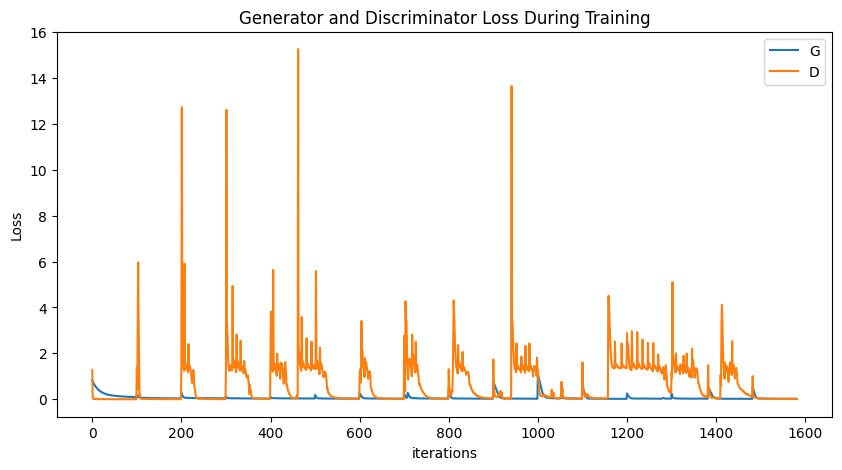

[1/16]


Loss_D: 0.0093	Loss_G: 4.8425 / 0.0345	D(x): 0.9995	D(G(z)): 0.0087 / 0.0079: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


[2/16]


Loss_D: 0.0259	Loss_G: 3.8579 / 0.0181	D(x): 0.9959	D(G(z)): 0.0215 / 0.0211: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


[3/16]


Loss_D: 0.0079	Loss_G: 5.0080 / 0.0212	D(x): 0.9987	D(G(z)): 0.0066 / 0.0067: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


[4/16]


Loss_D: 0.2837	Loss_G: 1.6067 / 0.0168	D(x): 0.9512	D(G(z)): 0.2084 / 0.2005: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


[5/16]


Loss_D: 0.0273	Loss_G: 3.7539 / 0.0200	D(x): 0.9974	D(G(z)): 0.0243 / 0.0234: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


[6/16]


Loss_D: 0.0304	Loss_G: 3.6748 / 0.0165	D(x): 0.9953	D(G(z)): 0.0253 / 0.0254: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


[7/16]


Loss_D: 0.0383	Loss_G: 3.4585 / 0.0188	D(x): 0.9950	D(G(z)): 0.0327 / 0.0315: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


[8/16]


Loss_D: 0.0098	Loss_G: 4.8425 / 0.0229	D(x): 0.9981	D(G(z)): 0.0078 / 0.0079: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[9/16]


Loss_D: 0.0040	Loss_G: 5.7245 / 0.0201	D(x): 0.9993	D(G(z)): 0.0034 / 0.0033: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


[10/16]


Loss_D: 0.2446	Loss_G: 1.3845 / 0.0217	D(x): 0.8940	D(G(z)): 0.1241 / 0.2505: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


[11/16]


Loss_D: 0.0077	Loss_G: 4.9607 / 0.0265	D(x): 0.9996	D(G(z)): 0.0073 / 0.0070: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


[12/16]


Loss_D: 1.1622	Loss_G: 1.1475 / 0.0149	D(x): 0.4257	D(G(z)): 0.2653 / 0.3174: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


[13/16]


Loss_D: 0.0178	Loss_G: 4.1318 / 0.0192	D(x): 0.9991	D(G(z)): 0.0167 / 0.0161: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


[14/16]


Loss_D: 0.5761	Loss_G: 1.0227 / 0.0182	D(x): 0.9633	D(G(z)): 0.4165 / 0.3596: 100%|██████████| 82/82 [00:06<00:00, 12.22it/s]


[15/16]


Loss_D: 0.0280	Loss_G: 3.7778 / 0.0175	D(x): 0.9997	D(G(z)): 0.0273 / 0.0229: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


[16/16]


Loss_D: 0.0093	Loss_G: 4.8020 / 0.0240	D(x): 0.9996	D(G(z)): 0.0089 / 0.0082: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


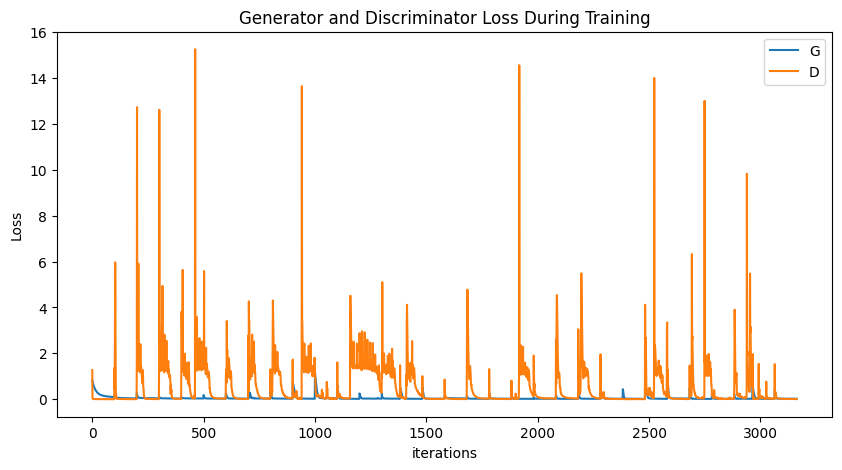

[1/16]


Loss_D: 0.0121	Loss_G: 4.6048 / 0.0289	D(x): 0.9992	D(G(z)): 0.0113 / 0.0100: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


[2/16]


Loss_D: 0.0183	Loss_G: 4.1692 / 0.0156	D(x): 0.9975	D(G(z)): 0.0157 / 0.0155: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


[3/16]


Loss_D: 0.0122	Loss_G: 4.6209 / 0.0202	D(x): 0.9976	D(G(z)): 0.0098 / 0.0098: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


[4/16]


Loss_D: 0.0054	Loss_G: 5.4289 / 0.0155	D(x): 0.9990	D(G(z)): 0.0044 / 0.0044: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


[5/16]


Loss_D: 0.0212	Loss_G: 4.0486 / 0.0173	D(x): 0.9966	D(G(z)): 0.0176 / 0.0174: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


[6/16]


Loss_D: 0.0102	Loss_G: 4.7481 / 0.0147	D(x): 0.9988	D(G(z)): 0.0089 / 0.0087: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


[7/16]


Loss_D: 0.0064	Loss_G: 5.2484 / 0.0176	D(x): 0.9989	D(G(z)): 0.0054 / 0.0053: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


[8/16]


Loss_D: 0.0034	Loss_G: 5.7219 / 0.0217	D(x): 1.0000	D(G(z)): 0.0033 / 0.0033: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


[9/16]


Loss_D: 0.0035	Loss_G: 5.7328 / 0.0169	D(x): 0.9999	D(G(z)): 0.0033 / 0.0032: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


[10/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0203	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:08<00:00, 12.50it/s]


[11/16]


Loss_D: 0.0097	Loss_G: 4.7330 / 0.0202	D(x): 0.9994	D(G(z)): 0.0091 / 0.0088: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


[12/16]


Loss_D: 0.0193	Loss_G: 4.1116 / 0.0132	D(x): 0.9991	D(G(z)): 0.0182 / 0.0164: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


[13/16]


Loss_D: 0.0092	Loss_G: 4.7588 / 0.0153	D(x): 0.9998	D(G(z)): 0.0090 / 0.0086: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


[14/16]


Loss_D: 0.2056	Loss_G: 1.9154 / 0.0199	D(x): 0.9953	D(G(z)): 0.1820 / 0.1473: 100%|██████████| 82/82 [00:06<00:00, 12.15it/s]


[15/16]


Loss_D: 0.0280	Loss_G: 3.6931 / 0.0151	D(x): 0.9999	D(G(z)): 0.0275 / 0.0249: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


[16/16]


Loss_D: 0.0073	Loss_G: 5.1279 / 0.0186	D(x): 0.9989	D(G(z)): 0.0062 / 0.0059: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


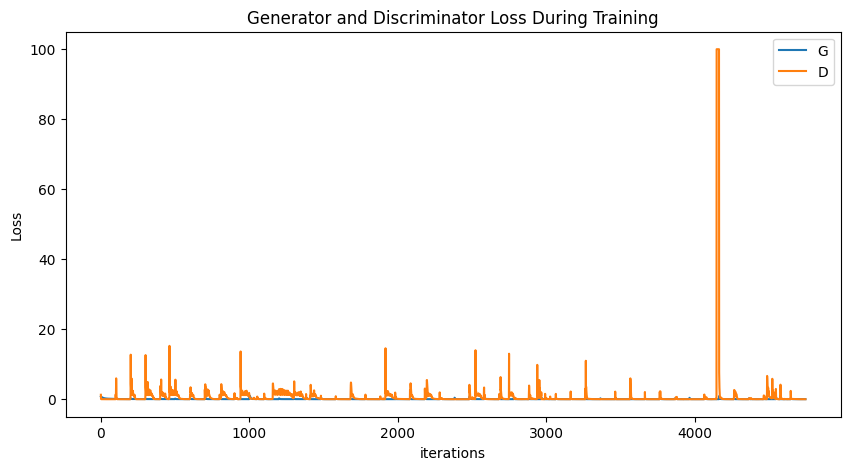

[1/16]


Loss_D: 0.0050	Loss_G: 5.3842 / 0.0269	D(x): 0.9995	D(G(z)): 0.0045 / 0.0046: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


[2/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0138	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


[3/16]


Loss_D: 0.0049	Loss_G: 5.4261 / 0.0185	D(x): 0.9997	D(G(z)): 0.0045 / 0.0044: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


[4/16]


Loss_D: 0.0038	Loss_G: 5.8313 / 0.0132	D(x): 0.9991	D(G(z)): 0.0029 / 0.0029: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


[5/16]


Loss_D: 0.0092	Loss_G: 4.7692 / 0.0154	D(x): 0.9997	D(G(z)): 0.0089 / 0.0085: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


[6/16]


Loss_D: 0.0091	Loss_G: 4.8769 / 0.0132	D(x): 0.9996	D(G(z)): 0.0087 / 0.0076: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


[7/16]


Loss_D: 0.0016	Loss_G: 6.6222 / 0.0165	D(x): 0.9998	D(G(z)): 0.0014 / 0.0013: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


[8/16]


Loss_D: 0.0016	Loss_G: 6.5199 / 0.0190	D(x): 0.9999	D(G(z)): 0.0015 / 0.0015: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


[9/16]


Loss_D: 0.0004	Loss_G: 7.7527 / 0.0163	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004: 100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


[10/16]


Loss_D: 2.4940	Loss_G: 2.5440 / 0.0191	D(x): 0.0857	D(G(z)): 0.0365 / 0.0786: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


[11/16]


Loss_D: 0.0067	Loss_G: 5.0629 / 0.0208	D(x): 0.9999	D(G(z)): 0.0066 / 0.0063: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


[12/16]


Loss_D: 0.0044	Loss_G: 5.4883 / 0.0131	D(x): 0.9998	D(G(z)): 0.0042 / 0.0041: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


[13/16]


Loss_D: 0.0050	Loss_G: 5.3241 / 0.0141	D(x): 1.0000	D(G(z)): 0.0049 / 0.0049: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


[14/16]


Loss_D: 0.0176	Loss_G: 4.2332 / 0.0174	D(x): 0.9999	D(G(z)): 0.0174 / 0.0145: 100%|██████████| 82/82 [00:06<00:00, 12.20it/s]


[15/16]


Loss_D: 0.0233	Loss_G: 3.8657 / 0.0153	D(x): 0.9993	D(G(z)): 0.0223 / 0.0209: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


[16/16]


Loss_D: 0.0080	Loss_G: 5.0293 / 0.0161	D(x): 0.9987	D(G(z)): 0.0067 / 0.0065: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


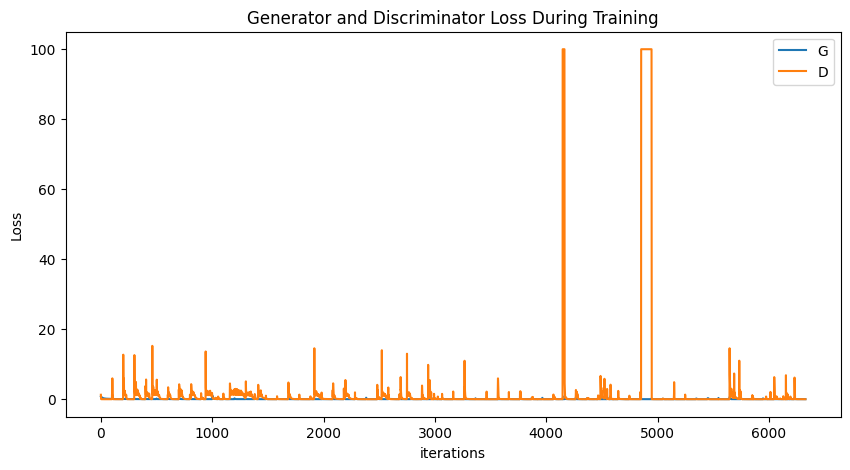

[1/16]


Loss_D: 0.0123	Loss_G: 4.5276 / 0.0245	D(x): 0.9995	D(G(z)): 0.0117 / 0.0108: 100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


[2/16]


Loss_D: 0.0082	Loss_G: 4.9935 / 0.0133	D(x): 0.9990	D(G(z)): 0.0071 / 0.0068: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


[3/16]


Loss_D: 0.0128	Loss_G: 4.6146 / 0.0164	D(x): 0.9970	D(G(z)): 0.0097 / 0.0099: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


[4/16]


Loss_D: 0.0192	Loss_G: 4.1421 / 0.0125	D(x): 0.9973	D(G(z)): 0.0163 / 0.0159: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


[5/16]


Loss_D: 0.0132	Loss_G: 4.4476 / 0.0135	D(x): 0.9989	D(G(z)): 0.0120 / 0.0117: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


[6/16]


Loss_D: 0.0177	Loss_G: 3.9941 / 0.0124	D(x): 0.9996	D(G(z)): 0.0171 / 0.0184: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


[7/16]


Loss_D: 0.0046	Loss_G: 5.4640 / 0.0150	D(x): 0.9998	D(G(z)): 0.0043 / 0.0042: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


[8/16]


Loss_D: 0.0017	Loss_G: 6.4550 / 0.0179	D(x): 0.9999	D(G(z)): 0.0016 / 0.0016: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


[9/16]


Loss_D: 0.0014	Loss_G: 6.6078 / 0.0166	D(x): 0.9999	D(G(z)): 0.0014 / 0.0013: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


[10/16]


Loss_D: 0.0129	Loss_G: 4.6392 / 0.0186	D(x): 0.9969	D(G(z)): 0.0097 / 0.0097: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


[11/16]


Loss_D: 0.0060	Loss_G: 5.1724 / 0.0231	D(x): 0.9998	D(G(z)): 0.0058 / 0.0057: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


[12/16]


Loss_D: 0.0066	Loss_G: 5.0803 / 0.0124	D(x): 0.9999	D(G(z)): 0.0065 / 0.0062: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


[13/16]


Loss_D: 0.0058	Loss_G: 5.2052 / 0.0152	D(x): 0.9998	D(G(z)): 0.0056 / 0.0055: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


[14/16]


Loss_D: 0.1867	Loss_G: 2.2081 / 0.0180	D(x): 0.9995	D(G(z)): 0.1699 / 0.1099: 100%|██████████| 82/82 [00:06<00:00, 12.23it/s]


[15/16]


Loss_D: 0.0084	Loss_G: 4.8161 / 0.0139	D(x): 1.0000	D(G(z)): 0.0083 / 0.0081: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


[16/16]


Loss_D: 0.0065	Loss_G: 5.1909 / 0.0162	D(x): 0.9992	D(G(z)): 0.0057 / 0.0056: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


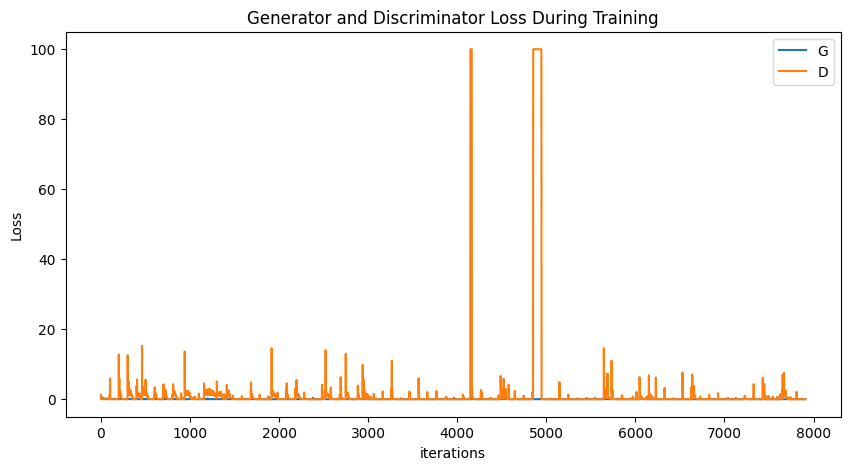

[1/16]


Loss_D: 0.0054	Loss_G: 5.2657 / 0.0226	D(x): 0.9999	D(G(z)): 0.0053 / 0.0052: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


[2/16]


Loss_D: 0.0063	Loss_G: 5.1476 / 0.0127	D(x): 0.9997	D(G(z)): 0.0060 / 0.0058: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


[3/16]


Loss_D: 0.0016	Loss_G: 6.5389 / 0.0164	D(x): 0.9999	D(G(z)): 0.0015 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


[4/16]


Loss_D: 0.0068	Loss_G: 5.0610 / 0.0123	D(x): 0.9998	D(G(z)): 0.0065 / 0.0063: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


[5/16]


Loss_D: 0.0046	Loss_G: 5.4733 / 0.0136	D(x): 0.9997	D(G(z)): 0.0043 / 0.0042: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


[6/16]


Loss_D: 0.0324	Loss_G: 3.6124 / 0.0118	D(x): 0.9952	D(G(z)): 0.0272 / 0.0270: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


[7/16]


Loss_D: 0.0043	Loss_G: 5.5202 / 0.0143	D(x): 0.9998	D(G(z)): 0.0041 / 0.0040: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


[8/16]


Loss_D: 0.0048	Loss_G: 5.4391 / 0.0170	D(x): 0.9996	D(G(z)): 0.0044 / 0.0043: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


[9/16]


Loss_D: 0.0012	Loss_G: 6.8536 / 0.0238	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


[10/16]


Loss_D: 0.0093	Loss_G: 4.8167 / 0.0155	D(x): 0.9990	D(G(z)): 0.0083 / 0.0081: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


[11/16]


Loss_D: 0.0054	Loss_G: 5.2977 / 0.0281	D(x): 0.9998	D(G(z)): 0.0051 / 0.0050: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


[12/16]


Loss_D: 0.0084	Loss_G: 4.8630 / 0.0123	D(x): 0.9997	D(G(z)): 0.0081 / 0.0077: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


[13/16]


Loss_D: 0.0237	Loss_G: 4.2964 / 0.0152	D(x): 0.9901	D(G(z)): 0.0137 / 0.0136: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


[14/16]


Loss_D: 0.0092	Loss_G: 4.7224 / 0.0143	D(x): 1.0000	D(G(z)): 0.0091 / 0.0089: 100%|██████████| 82/82 [00:06<00:00, 12.38it/s]


[15/16]


Loss_D: 0.0071	Loss_G: 5.0138 / 0.0136	D(x): 0.9999	D(G(z)): 0.0070 / 0.0066: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


[16/16]


Loss_D: 0.0012	Loss_G: 6.8239 / 0.0152	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


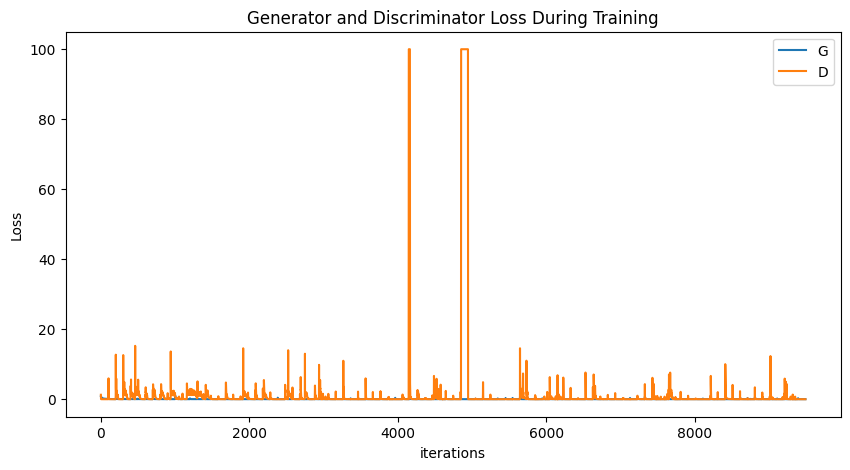

[1/16]


Loss_D: 0.0036	Loss_G: 5.6797 / 0.0215	D(x): 0.9999	D(G(z)): 0.0035 / 0.0034: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


[2/16]


Loss_D: 0.0034	Loss_G: 5.8355 / 0.0119	D(x): 0.9996	D(G(z)): 0.0031 / 0.0029: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


[3/16]


Loss_D: 0.0011	Loss_G: 6.9094 / 0.0159	D(x): 0.9999	D(G(z)): 0.0010 / 0.0010: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


[4/16]


Loss_D: 0.0022	Loss_G: 6.1990 / 0.0114	D(x): 0.9999	D(G(z)): 0.0021 / 0.0020: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


[5/16]


Loss_D: 0.0041	Loss_G: 5.6067 / 0.0122	D(x): 0.9997	D(G(z)): 0.0038 / 0.0037: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


[6/16]


Loss_D: 0.0073	Loss_G: 5.0928 / 0.0114	D(x): 0.9997	D(G(z)): 0.0070 / 0.0061: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


[7/16]


Loss_D: 0.0009	Loss_G: 7.0612 / 0.0134	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


[8/16]


Loss_D: 0.0028	Loss_G: 5.9753 / 0.0166	D(x): 0.9998	D(G(z)): 0.0026 / 0.0025: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


[9/16]


Loss_D: 0.0016	Loss_G: 6.5020 / 0.0189	D(x): 0.9999	D(G(z)): 0.0015 / 0.0015: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


[10/16]


Loss_D: 0.0517	Loss_G: 4.1738 / 0.0152	D(x): 0.9536	D(G(z)): 0.0041 / 0.0154: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


[11/16]


Loss_D: 0.0028	Loss_G: 5.9980 / 0.0179	D(x): 0.9998	D(G(z)): 0.0026 / 0.0025: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


[12/16]


Loss_D: 0.0121	Loss_G: 4.5039 / 0.0145	D(x): 0.9999	D(G(z)): 0.0120 / 0.0111: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


[13/16]


Loss_D: 0.0021	Loss_G: 6.2879 / 0.0158	D(x): 0.9998	D(G(z)): 0.0019 / 0.0019: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


[14/16]


Loss_D: 0.0137	Loss_G: 4.3536 / 0.0140	D(x): 1.0000	D(G(z)): 0.0136 / 0.0129: 100%|██████████| 82/82 [00:06<00:00, 12.48it/s]


[15/16]


Loss_D: 0.0785	Loss_G: 2.9268 / 0.0133	D(x): 1.0000	D(G(z)): 0.0755 / 0.0536: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s] 


[16/16]


Loss_D: 0.0016	Loss_G: 6.5578 / 0.0164	D(x): 0.9999	D(G(z)): 0.0014 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


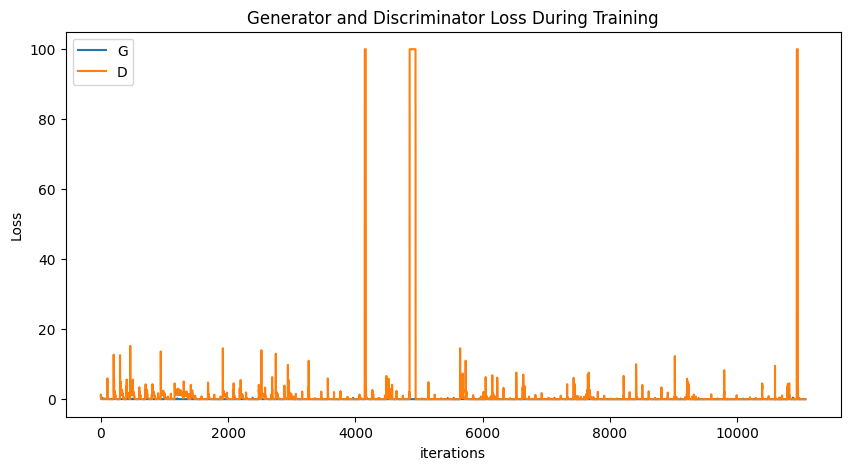

[1/16]


Loss_D: 0.0051	Loss_G: 5.3774 / 0.0202	D(x): 0.9999	D(G(z)): 0.0049 / 0.0046: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


[2/16]


Loss_D: 0.0056	Loss_G: 5.8182 / 0.0114	D(x): 0.9970	D(G(z)): 0.0026 / 0.0030: 100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


[3/16]


Loss_D: 0.0016	Loss_G: 6.6004 / 0.0143	D(x): 0.9998	D(G(z)): 0.0013 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[4/16]


Loss_D: 0.0054	Loss_G: 5.2710 / 0.0117	D(x): 0.9999	D(G(z)): 0.0053 / 0.0051: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


[5/16]


Loss_D: 0.0083	Loss_G: 4.8952 / 0.0127	D(x): 0.9995	D(G(z)): 0.0078 / 0.0075: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


[6/16]


Loss_D: 0.0059	Loss_G: 5.2903 / 0.0107	D(x): 0.9993	D(G(z)): 0.0052 / 0.0050: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


[7/16]


Loss_D: 0.0008	Loss_G: 7.1019 / 0.0131	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


[8/16]


Loss_D: 0.0016	Loss_G: 6.4945 / 0.0159	D(x): 1.0000	D(G(z)): 0.0016 / 0.0015: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


[9/16]


Loss_D: 0.0002	Loss_G: 8.5089 / 0.0235	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


[10/16]


Loss_D: 0.0039	Loss_G: 5.6189 / 0.0142	D(x): 0.9999	D(G(z)): 0.0038 / 0.0036: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


[11/16]


Loss_D: 0.0031	Loss_G: 5.9145 / 0.0169	D(x): 0.9996	D(G(z)): 0.0028 / 0.0027: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


[12/16]


Loss_D: 0.0055	Loss_G: 5.2668 / 0.0108	D(x): 1.0000	D(G(z)): 0.0054 / 0.0052: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


[13/16]


Loss_D: 0.0801	Loss_G: 2.7039 / 0.0156	D(x): 0.9793	D(G(z)): 0.0574 / 0.0669: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s] 


[14/16]


Loss_D: 0.0124	Loss_G: 4.4368 / 0.0169	D(x): 1.0000	D(G(z)): 0.0124 / 0.0118: 100%|██████████| 82/82 [00:06<00:00, 12.34it/s]


[15/16]


Loss_D: 0.0034	Loss_G: 5.7425 / 0.0138	D(x): 0.9999	D(G(z)): 0.0032 / 0.0032: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


[16/16]


Loss_D: 0.0061	Loss_G: 5.3109 / 0.0147	D(x): 0.9989	D(G(z)): 0.0050 / 0.0049: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


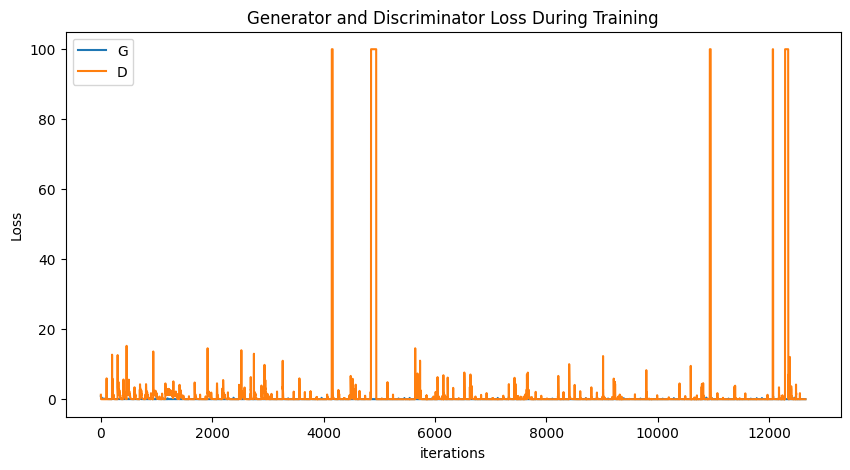

[1/16]


Loss_D: 0.0044	Loss_G: 5.4807 / 0.0199	D(x): 0.9999	D(G(z)): 0.0043 / 0.0042: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


[2/16]


Loss_D: 0.0201	Loss_G: 4.1511 / 0.0117	D(x): 0.9960	D(G(z)): 0.0159 / 0.0157: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


[3/16]


Loss_D: 0.0011	Loss_G: 6.9449 / 0.0143	D(x): 0.9999	D(G(z)): 0.0010 / 0.0010: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


[4/16]


Loss_D: 0.0032	Loss_G: 5.7934 / 0.0118	D(x): 0.9999	D(G(z)): 0.0031 / 0.0030: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


[5/16]


Loss_D: 0.0071	Loss_G: 5.0385 / 0.0110	D(x): 0.9999	D(G(z)): 0.0069 / 0.0065: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[6/16]


Loss_D: 0.0065	Loss_G: 5.2961 / 0.0107	D(x): 0.9987	D(G(z)): 0.0051 / 0.0050: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


[7/16]


Loss_D: 0.0014	Loss_G: 6.6034 / 0.0126	D(x): 1.0000	D(G(z)): 0.0014 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


[8/16]


Loss_D: 0.0019	Loss_G: 6.3341 / 0.0167	D(x): 1.0000	D(G(z)): 0.0018 / 0.0018: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


[9/16]


Loss_D: 0.0005	Loss_G: 7.7310 / 0.0111	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


[10/16]


Loss_D: 0.0078	Loss_G: 5.0476 / 0.0170	D(x): 1.0000	D(G(z)): 0.0078 / 0.0064: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


[11/16]


Loss_D: 0.0063	Loss_G: 5.2753 / 0.0200	D(x): 0.9990	D(G(z)): 0.0053 / 0.0051: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


[12/16]


Loss_D: 0.0350	Loss_G: 3.5506 / 0.0113	D(x): 0.9986	D(G(z)): 0.0331 / 0.0287: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


[13/16]


Loss_D: 0.0016	Loss_G: 6.4408 / 0.0226	D(x): 1.0000	D(G(z)): 0.0016 / 0.0016: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


[14/16]


Loss_D: 0.0116	Loss_G: 4.5228 / 0.0190	D(x): 1.0000	D(G(z)): 0.0116 / 0.0109: 100%|██████████| 82/82 [00:07<00:00, 11.67it/s]


[15/16]


Loss_D: 0.0076	Loss_G: 4.9450 / 0.0120	D(x): 1.0000	D(G(z)): 0.0075 / 0.0071: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


[16/16]


Loss_D: 0.0024	Loss_G: 6.1683 / 0.0144	D(x): 0.9997	D(G(z)): 0.0021 / 0.0021: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


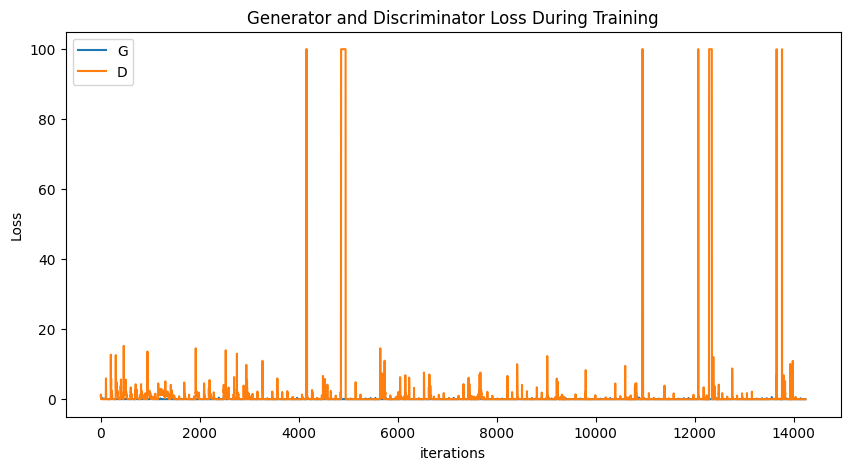

[1/16]


Loss_D: 0.0023	Loss_G: 6.1247 / 0.0188	D(x): 0.9999	D(G(z)): 0.0022 / 0.0022: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


[2/16]


Loss_D: 0.0099	Loss_G: 4.8140 / 0.0110	D(x): 0.9992	D(G(z)): 0.0090 / 0.0081: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


[3/16]


Loss_D: 0.0013	Loss_G: 6.6795 / 0.0159	D(x): 1.0000	D(G(z)): 0.0013 / 0.0013: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[4/16]


Loss_D: 0.0001	Loss_G: 9.3326 / 0.0108	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


[5/16]


Loss_D: 0.0044	Loss_G: 5.5017 / 0.0110	D(x): 1.0000	D(G(z)): 0.0044 / 0.0041: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


[6/16]


Loss_D: 0.0071	Loss_G: 5.0886 / 0.0101	D(x): 0.9991	D(G(z)): 0.0062 / 0.0062: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


[7/16]


Loss_D: 0.0014	Loss_G: 6.6011 / 0.0123	D(x): 1.0000	D(G(z)): 0.0014 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


[8/16]


Loss_D: 0.0016	Loss_G: 6.4970 / 0.0149	D(x): 1.0000	D(G(z)): 0.0016 / 0.0015: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


[9/16]


Loss_D: 0.0003	Loss_G: 8.1452 / 0.0168	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


[10/16]


Loss_D: 0.0206	Loss_G: 4.0356 / 0.0153	D(x): 1.0000	D(G(z)): 0.0204 / 0.0177: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


[11/16]


Loss_D: 0.0046	Loss_G: 5.5302 / 0.0168	D(x): 0.9995	D(G(z)): 0.0040 / 0.0040: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


[12/16]


Loss_D: 0.0097	Loss_G: 4.7111 / 0.0116	D(x): 0.9998	D(G(z)): 0.0095 / 0.0090: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


[13/16]


Loss_D: 0.0017	Loss_G: 6.4378 / 0.0148	D(x): 1.0000	D(G(z)): 0.0017 / 0.0016: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


[14/16]


Loss_D: 0.0078	Loss_G: 4.9123 / 0.0128	D(x): 1.0000	D(G(z)): 0.0078 / 0.0074: 100%|██████████| 82/82 [00:06<00:00, 12.27it/s]


[15/16]


Loss_D: 0.0005	Loss_G: 7.5681 / 0.0117	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


[16/16]


Loss_D: 0.0014	Loss_G: 6.9810 / 0.0144	D(x): 0.9995	D(G(z)): 0.0009 / 0.0009: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


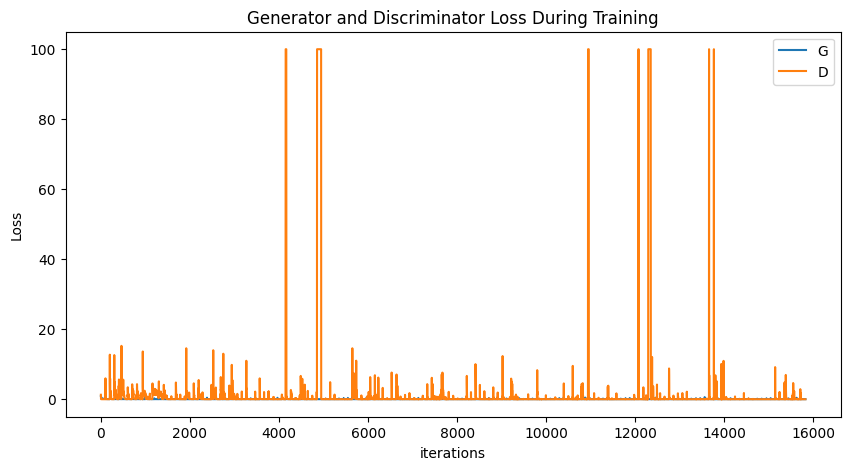

[1/16]


Loss_D: 0.0015	Loss_G: 6.5586 / 0.0178	D(x): 1.0000	D(G(z)): 0.0015 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


[2/16]


Loss_D: 0.0069	Loss_G: 5.1623 / 0.0102	D(x): 1.0000	D(G(z)): 0.0069 / 0.0057: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


[3/16]


Loss_D: 0.0013	Loss_G: 6.6454 / 0.0147	D(x): 1.0000	D(G(z)): 0.0013 / 0.0013: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


[4/16]


Loss_D: 0.0001	Loss_G: 9.6295 / 0.0096	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


[5/16]


Loss_D: 0.0031	Loss_G: 5.8218 / 0.0110	D(x): 1.0000	D(G(z)): 0.0031 / 0.0030: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


[6/16]


Loss_D: 0.0080	Loss_G: 5.0756 / 0.0104	D(x): 0.9999	D(G(z)): 0.0078 / 0.0062: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


[7/16]


Loss_D: 0.0009	Loss_G: 7.0758 / 0.0122	D(x): 1.0000	D(G(z)): 0.0009 / 0.0008: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


[8/16]


Loss_D: 0.0013	Loss_G: 6.6571 / 0.0150	D(x): 1.0000	D(G(z)): 0.0013 / 0.0013: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


[9/16]


Loss_D: 0.0059	Loss_G: 5.2111 / 0.0172	D(x): 0.9997	D(G(z)): 0.0056 / 0.0055: 100%|██████████| 100/100 [00:08<00:00, 12.30it/s]


[10/16]


Loss_D: 0.0103	Loss_G: 4.7006 / 0.0130	D(x): 1.0000	D(G(z)): 0.0102 / 0.0091: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


[11/16]


Loss_D: 0.0077	Loss_G: 5.0493 / 0.0156	D(x): 0.9989	D(G(z)): 0.0065 / 0.0064: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


[12/16]


Loss_D: 0.0128	Loss_G: 4.5135 / 0.0115	D(x): 1.0000	D(G(z)): 0.0127 / 0.0110: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


[13/16]


Loss_D: 0.0331	Loss_G: 3.1491 / 0.0132	D(x): 0.9950	D(G(z)): 0.0276 / 0.0429: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s] 


[14/16]


Loss_D: 0.0561	Loss_G: 3.0035 / 0.0107	D(x): 1.0000	D(G(z)): 0.0546 / 0.0496: 100%|██████████| 82/82 [00:06<00:00, 12.36it/s]


[15/16]


Loss_D: 0.0050	Loss_G: 5.3394 / 0.0124	D(x): 0.9999	D(G(z)): 0.0049 / 0.0048: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


[16/16]


Loss_D: 0.0154	Loss_G: 4.2395 / 0.0119	D(x): 1.0000	D(G(z)): 0.0152 / 0.0144: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


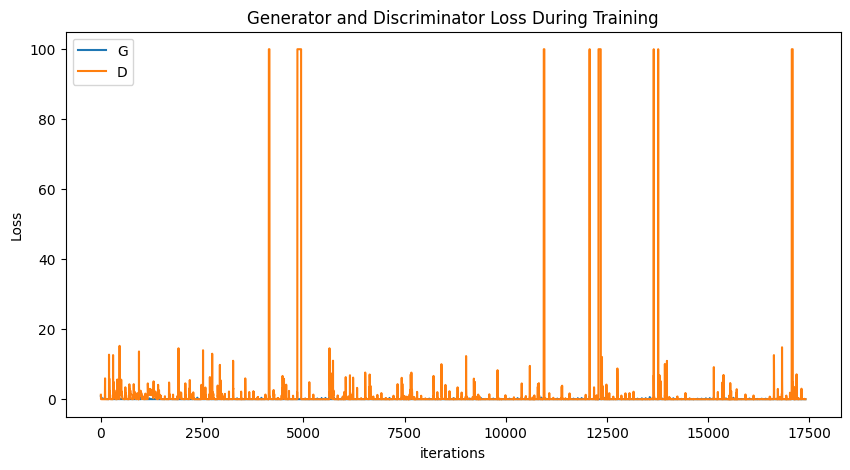

[1/16]


Loss_D: 0.0045	Loss_G: 5.4727 / 0.0175	D(x): 0.9999	D(G(z)): 0.0043 / 0.0042: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


[2/16]


Loss_D: 0.0109	Loss_G: 4.7691 / 0.0103	D(x): 1.0000	D(G(z)): 0.0109 / 0.0085: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[3/16]


Loss_D: 0.0056	Loss_G: 5.2368 / 0.0144	D(x): 0.9999	D(G(z)): 0.0055 / 0.0053: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


[4/16]


Loss_D: 0.0036	Loss_G: 5.6379 / 0.0112	D(x): 1.0000	D(G(z)): 0.0036 / 0.0036: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


[5/16]


Loss_D: 0.0058	Loss_G: 5.2184 / 0.0114	D(x): 1.0000	D(G(z)): 0.0058 / 0.0054: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


[6/16]


Loss_D: 0.0106	Loss_G: 4.4829 / 0.0103	D(x): 0.9998	D(G(z)): 0.0104 / 0.0113: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


[7/16]


Loss_D: 0.0019	Loss_G: 6.2773 / 0.0122	D(x): 1.0000	D(G(z)): 0.0019 / 0.0019: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


[8/16]


Loss_D: 0.0020	Loss_G: 6.3069 / 0.0145	D(x): 0.9999	D(G(z)): 0.0019 / 0.0018: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


[9/16]


Loss_D: 0.0006	Loss_G: 7.4003 / 0.0165	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


[10/16]


Loss_D: 0.0056	Loss_G: 5.2542 / 0.0174	D(x): 0.9999	D(G(z)): 0.0055 / 0.0052: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


[11/16]


Loss_D: 0.0031	Loss_G: 5.7949 / 0.0148	D(x): 1.0000	D(G(z)): 0.0031 / 0.0030: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


[12/16]


Loss_D: 0.0326	Loss_G: 3.6341 / 0.0114	D(x): 0.9968	D(G(z)): 0.0289 / 0.0264: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


[13/16]


Loss_D: 0.0160	Loss_G: 4.3244 / 0.0152	D(x): 1.0000	D(G(z)): 0.0158 / 0.0132: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


[14/16]


Loss_D: 0.0104	Loss_G: 4.6101 / 0.0136	D(x): 1.0000	D(G(z)): 0.0104 / 0.0100: 100%|██████████| 82/82 [00:06<00:00, 12.35it/s]


[15/16]


Loss_D: 0.0019	Loss_G: 6.2612 / 0.0111	D(x): 1.0000	D(G(z)): 0.0019 / 0.0019: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


[16/16]


Loss_D: 0.0022	Loss_G: 6.3326 / 0.0135	D(x): 0.9996	D(G(z)): 0.0018 / 0.0018: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


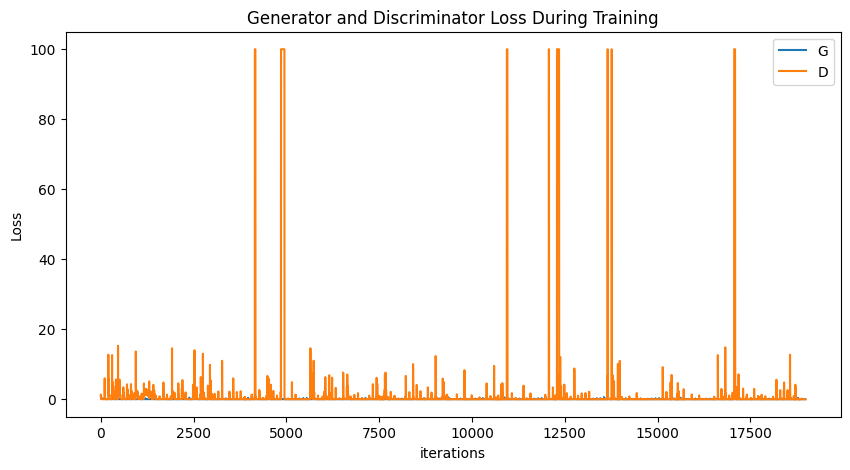

[1/16]


Loss_D: 0.0013	Loss_G: 6.6966 / 0.0174	D(x): 1.0000	D(G(z)): 0.0013 / 0.0012: 100%|██████████| 100/100 [00:09<00:00, 10.46it/s]


[2/16]


Loss_D: 0.0051	Loss_G: 5.4103 / 0.0103	D(x): 1.0000	D(G(z)): 0.0051 / 0.0045: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


[3/16]


Loss_D: 0.0017	Loss_G: 6.4282 / 0.0147	D(x): 1.0000	D(G(z)): 0.0017 / 0.0016: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


[4/16]


Loss_D: 0.0071	Loss_G: 5.0152 / 0.0108	D(x): 0.9999	D(G(z)): 0.0070 / 0.0066: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


[5/16]


Loss_D: 0.0129	Loss_G: 4.4711 / 0.0099	D(x): 0.9999	D(G(z)): 0.0127 / 0.0114: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


[6/16]


Loss_D: 0.0068	Loss_G: 5.1824 / 0.0106	D(x): 0.9999	D(G(z)): 0.0067 / 0.0056: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


[7/16]


Loss_D: 0.0006	Loss_G: 7.3658 / 0.0117	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


[8/16]


Loss_D: 0.0013	Loss_G: 6.7047 / 0.0149	D(x): 1.0000	D(G(z)): 0.0013 / 0.0012: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


[9/16]


Loss_D: 0.0065	Loss_G: 5.2215 / 0.0181	D(x): 0.9990	D(G(z)): 0.0055 / 0.0054: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


[10/16]


Loss_D: 0.0306	Loss_G: 3.7407 / 0.0104	D(x): 1.0000	D(G(z)): 0.0301 / 0.0237: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


[11/16]


Loss_D: 0.0015	Loss_G: 6.6320 / 0.0222	D(x): 0.9998	D(G(z)): 0.0013 / 0.0013: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


[12/16]


Loss_D: 0.0139	Loss_G: 4.5112 / 0.0126	D(x): 0.9980	D(G(z)): 0.0119 / 0.0110: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


[13/16]


Loss_D: 0.0085	Loss_G: 4.9294 / 0.0120	D(x): 0.9992	D(G(z)): 0.0077 / 0.0072: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


[14/16]


Loss_D: 0.0082	Loss_G: 4.8736 / 0.0140	D(x): 1.0000	D(G(z)): 0.0082 / 0.0076: 100%|██████████| 82/82 [00:06<00:00, 12.27it/s]


[15/16]


Loss_D: 0.0034	Loss_G: 5.6986 / 0.0106	D(x): 0.9997	D(G(z)): 0.0031 / 0.0034: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


[16/16]


Loss_D: 0.0020	Loss_G: 6.7130 / 0.0116	D(x): 0.9992	D(G(z)): 0.0012 / 0.0012: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


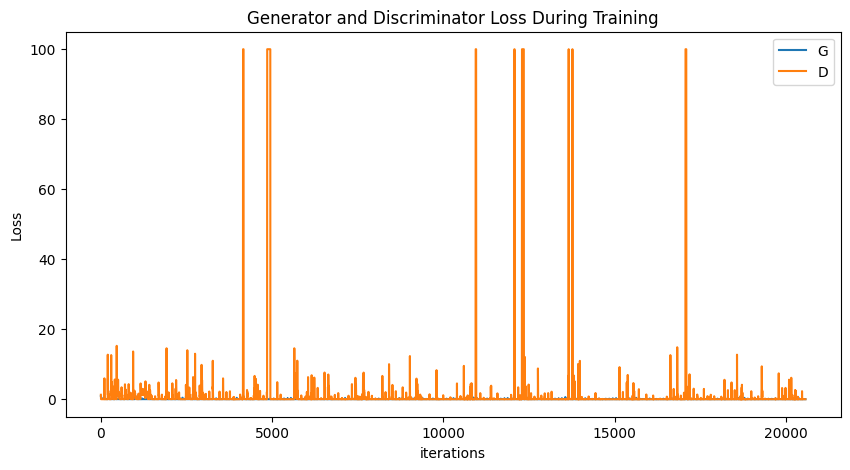

[1/16]


Loss_D: 0.0014	Loss_G: 6.6210 / 0.0165	D(x): 1.0000	D(G(z)): 0.0014 / 0.0013: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


[2/16]


Loss_D: 0.0309	Loss_G: 3.6405 / 0.0094	D(x): 0.9986	D(G(z)): 0.0291 / 0.0262: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


[3/16]


Loss_D: 0.0058	Loss_G: 5.2308 / 0.0165	D(x): 1.0000	D(G(z)): 0.0057 / 0.0053: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


[4/16]


Loss_D: 0.0019	Loss_G: 6.3087 / 0.0099	D(x): 1.0000	D(G(z)): 0.0019 / 0.0018: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


[5/16]


Loss_D: 0.0048	Loss_G: 5.4508 / 0.0103	D(x): 0.9999	D(G(z)): 0.0046 / 0.0043: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


[6/16]


Loss_D: 6.8028	Loss_G: 5.7354 / 0.0095	D(x): 0.0011	D(G(z)): 0.0009 / 0.0032: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


[7/16]


Loss_D: 0.0035	Loss_G: 5.7207 / 0.0113	D(x): 0.9998	D(G(z)): 0.0033 / 0.0033: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


[8/16]


Loss_D: 0.0142	Loss_G: 5.1029 / 0.0141	D(x): 0.9911	D(G(z)): 0.0052 / 0.0061: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


[9/16]


Loss_D: 0.0145	Loss_G: 4.3392 / 0.0178	D(x): 0.9990	D(G(z)): 0.0134 / 0.0130: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


[10/16]


Loss_D: 0.0244	Loss_G: 3.8470 / 0.0106	D(x): 0.9998	D(G(z)): 0.0239 / 0.0213: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


[11/16]


Loss_D: 0.0043	Loss_G: 5.6724 / 0.0152	D(x): 0.9992	D(G(z)): 0.0035 / 0.0034: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s]


[12/16]


Loss_D: 0.0323	Loss_G: 3.6067 / 0.0140	D(x): 0.9966	D(G(z)): 0.0285 / 0.0271: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


[13/16]


Loss_D: 0.0313	Loss_G: 3.6666 / 0.0153	D(x): 0.9831	D(G(z)): 0.0142 / 0.0256: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


[14/16]


Loss_D: 0.0136	Loss_G: 4.3737 / 0.0147	D(x): 1.0000	D(G(z)): 0.0135 / 0.0126: 100%|██████████| 82/82 [00:06<00:00, 12.38it/s]


[15/16]


Loss_D: 0.0163	Loss_G: 4.1681 / 0.0104	D(x): 1.0000	D(G(z)): 0.0162 / 0.0155: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


[16/16]


Loss_D: 0.0057	Loss_G: 5.4781 / 0.0109	D(x): 0.9985	D(G(z)): 0.0042 / 0.0042: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


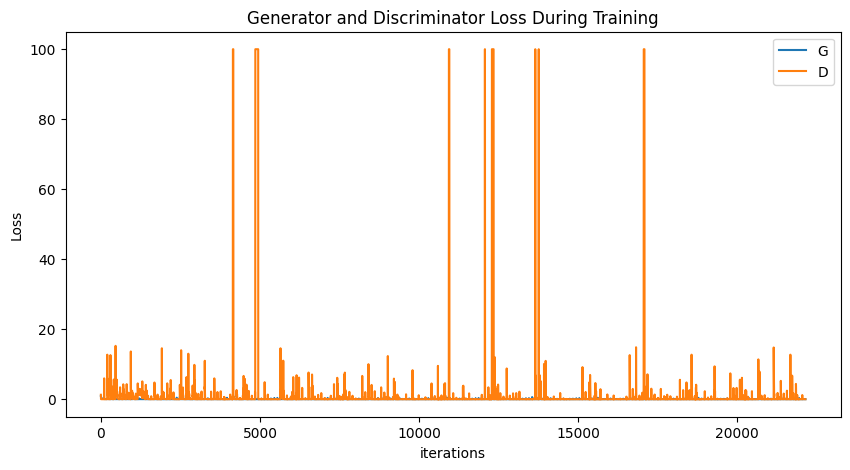

[1/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0159	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


[2/16]


Loss_D: 0.0190	Loss_G: 4.1735 / 0.0096	D(x): 0.9999	D(G(z)): 0.0188 / 0.0154: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


[3/16]


Loss_D: 0.0053	Loss_G: 5.2934 / 0.0135	D(x): 1.0000	D(G(z)): 0.0053 / 0.0050: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


[4/16]


Loss_D: 0.0036	Loss_G: 5.6423 / 0.0094	D(x): 1.0000	D(G(z)): 0.0036 / 0.0035: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


[5/16]


Loss_D: 0.0041	Loss_G: 5.5886 / 0.0092	D(x): 1.0000	D(G(z)): 0.0040 / 0.0037: 100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


[6/16]


Loss_D: 0.0283	Loss_G: 3.7877 / 0.0093	D(x): 0.9995	D(G(z)): 0.0275 / 0.0226: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


[7/16]


Loss_D: 0.0006	Loss_G: 7.5048 / 0.0110	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006: 100%|██████████| 100/100 [00:08<00:00, 11.38it/s]


[8/16]


Loss_D: 0.0005	Loss_G: 7.8463 / 0.0147	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[9/16]


Loss_D: 0.0014	Loss_G: 6.5671 / 0.0116	D(x): 1.0000	D(G(z)): 0.0014 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


[10/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0133	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


[11/16]


Loss_D: 0.0010	Loss_G: 7.1598 / 0.0149	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


[12/16]


Loss_D: 0.0199	Loss_G: 4.0929 / 0.0127	D(x): 0.9983	D(G(z)): 0.0180 / 0.0167: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


[13/16]


Loss_D: 0.0083	Loss_G: 4.8891 / 0.0161	D(x): 1.0000	D(G(z)): 0.0082 / 0.0075: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


[14/16]


Loss_D: 0.0146	Loss_G: 4.2976 / 0.0136	D(x): 1.0000	D(G(z)): 0.0145 / 0.0136: 100%|██████████| 82/82 [00:06<00:00, 12.41it/s]


[15/16]


Loss_D: 0.0042	Loss_G: 5.5431 / 0.0116	D(x): 0.9998	D(G(z)): 0.0039 / 0.0039: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


[16/16]


Loss_D: 0.0038	Loss_G: 5.6989 / 0.0119	D(x): 0.9997	D(G(z)): 0.0035 / 0.0033: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


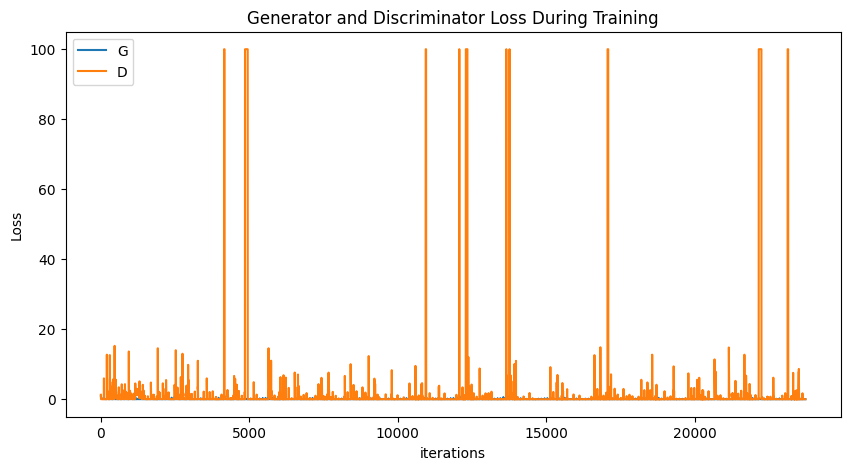

[1/16]


Loss_D: 0.0084	Loss_G: 4.8496 / 0.0153	D(x): 1.0000	D(G(z)): 0.0084 / 0.0078: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


[2/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0098	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


[3/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0136	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


[4/16]


Loss_D: 0.0036	Loss_G: 5.6457 / 0.0099	D(x): 1.0000	D(G(z)): 0.0036 / 0.0035: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


[5/16]


Loss_D: 0.0060	Loss_G: 5.1568 / 0.0101	D(x): 1.0000	D(G(z)): 0.0060 / 0.0058: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


[6/16]


Loss_D: 0.0112	Loss_G: 4.5490 / 0.0089	D(x): 0.9995	D(G(z)): 0.0107 / 0.0106: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


[7/16]


Loss_D: 0.0017	Loss_G: 6.3653 / 0.0107	D(x): 1.0000	D(G(z)): 0.0017 / 0.0017: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


[8/16]


Loss_D: 0.0034	Loss_G: 6.1672 / 0.0131	D(x): 0.9986	D(G(z)): 0.0020 / 0.0021: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


[9/16]


Loss_D: 0.0024	Loss_G: 6.1100 / 0.0125	D(x): 0.9999	D(G(z)): 0.0023 / 0.0022: 100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


[10/16]


Loss_D: 0.0803	Loss_G: 2.7511 / 0.0122	D(x): 0.9993	D(G(z)): 0.0765 / 0.0639: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


[11/16]


Loss_D: 0.0073	Loss_G: 5.0912 / 0.0161	D(x): 0.9990	D(G(z)): 0.0063 / 0.0062: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


[12/16]


Loss_D: 0.0141	Loss_G: 4.3439 / 0.0101	D(x): 1.0000	D(G(z)): 0.0140 / 0.0130: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


[13/16]


Loss_D: 0.0008	Loss_G: 7.1568 / 0.0220	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


[14/16]


Loss_D: 0.0078	Loss_G: 4.9029 / 0.0131	D(x): 1.0000	D(G(z)): 0.0077 / 0.0074: 100%|██████████| 82/82 [00:06<00:00, 12.19it/s]


[15/16]


Loss_D: 0.0187	Loss_G: 4.0994 / 0.0123	D(x): 1.0000	D(G(z)): 0.0185 / 0.0166: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


[16/16]


Loss_D: 0.0051	Loss_G: 5.4003 / 0.0138	D(x): 0.9995	D(G(z)): 0.0047 / 0.0045: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


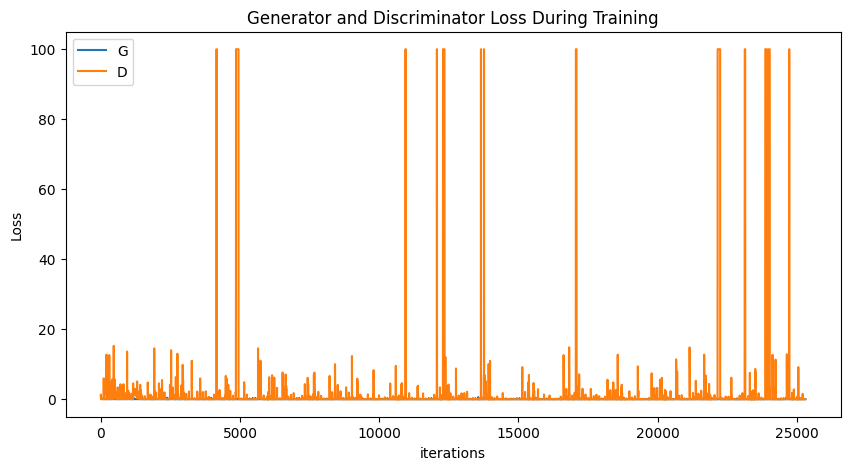

[1/16]


Loss_D: 0.0015	Loss_G: 6.5775 / 0.0152	D(x): 0.9999	D(G(z)): 0.0014 / 0.0014: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


[2/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0091	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


[3/16]


Loss_D: 0.0028	Loss_G: 5.8955 / 0.0151	D(x): 0.9999	D(G(z)): 0.0028 / 0.0028: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


[4/16]


Loss_D: 0.0072	Loss_G: 5.0718 / 0.0092	D(x): 0.9995	D(G(z)): 0.0067 / 0.0063: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


[5/16]


Loss_D: 0.0125	Loss_G: 4.5024 / 0.0093	D(x): 1.0000	D(G(z)): 0.0124 / 0.0111: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


[6/16]


Loss_D: 0.0124	Loss_G: 4.5799 / 0.0086	D(x): 0.9998	D(G(z)): 0.0121 / 0.0103: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


[7/16]


Loss_D: 0.0009	Loss_G: 6.9757 / 0.0106	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009: 100%|██████████| 100/100 [00:08<00:00, 11.38it/s]


[8/16]


Loss_D: 0.0016	Loss_G: 6.8879 / 0.0141	D(x): 0.9994	D(G(z)): 0.0010 / 0.0010: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[9/16]


Loss_D: 0.0034	Loss_G: 5.7114 / 0.0118	D(x): 1.0000	D(G(z)): 0.0034 / 0.0033: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


[10/16]


Loss_D: 0.0156	Loss_G: 4.4404 / 0.0124	D(x): 1.0000	D(G(z)): 0.0155 / 0.0118: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


[11/16]


Loss_D: 0.0019	Loss_G: 6.4959 / 0.0190	D(x): 0.9996	D(G(z)): 0.0015 / 0.0015: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


[12/16]


Loss_D: 0.0011	Loss_G: 6.7921 / 0.0101	D(x): 1.0000	D(G(z)): 0.0011 / 0.0011: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


[13/16]


Loss_D: 0.0006	Loss_G: 7.3630 / 0.0190	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


[14/16]


Loss_D: 0.0066	Loss_G: 5.0825 / 0.0132	D(x): 1.0000	D(G(z)): 0.0066 / 0.0062: 100%|██████████| 82/82 [00:07<00:00, 11.71it/s]


[15/16]


Loss_D: 1.1205	Loss_G: 2.2782 / 0.0122	D(x): 0.9948	D(G(z)): 0.6722 / 0.1025: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


[16/16]


Loss_D: 0.0078	Loss_G: 4.9515 / 0.0115	D(x): 0.9995	D(G(z)): 0.0073 / 0.0071: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


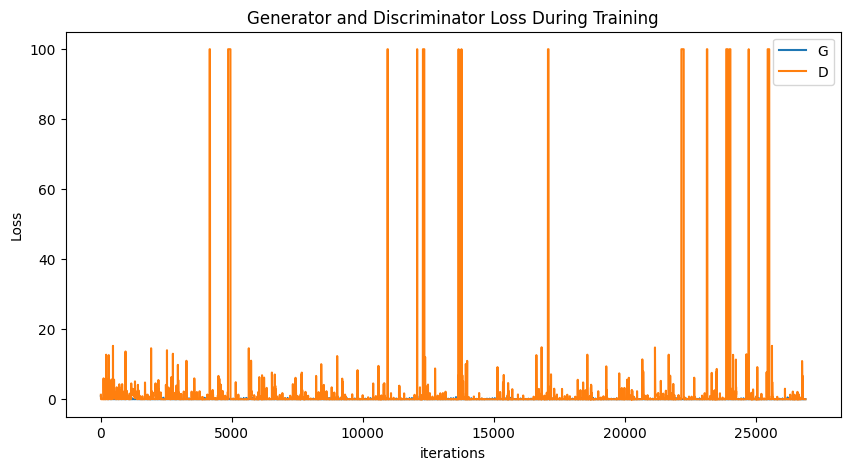

[1/16]


Loss_D: 0.0031	Loss_G: 5.8278 / 0.0150	D(x): 0.9999	D(G(z)): 0.0030 / 0.0029: 100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


[2/16]


Loss_D: 0.0168	Loss_G: 4.2915 / 0.0096	D(x): 0.9981	D(G(z)): 0.0148 / 0.0137: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


[3/16]


Loss_D: 0.0146	Loss_G: 4.3129 / 0.0138	D(x): 1.0000	D(G(z)): 0.0145 / 0.0134: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[4/16]


Loss_D: 0.0007	Loss_G: 7.2164 / 0.0118	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


[5/16]


Loss_D: 0.0033	Loss_G: 5.7637 / 0.0110	D(x): 1.0000	D(G(z)): 0.0033 / 0.0031: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[6/16]


Loss_D: 0.0074	Loss_G: 5.0605 / 0.0098	D(x): 0.9999	D(G(z)): 0.0073 / 0.0063: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


[7/16]


Loss_D: 0.0022	Loss_G: 6.1635 / 0.0109	D(x): 0.9999	D(G(z)): 0.0022 / 0.0021: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


[8/16]


Loss_D: 0.0142	Loss_G: 4.4964 / 0.0132	D(x): 0.9971	D(G(z)): 0.0112 / 0.0111: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


[9/16]


Loss_D: 0.0017	Loss_G: 6.5445 / 0.0126	D(x): 0.9998	D(G(z)): 0.0015 / 0.0014: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


[10/16]


Loss_D: 0.0178	Loss_G: 4.3911 / 0.0149	D(x): 0.9999	D(G(z)): 0.0175 / 0.0124: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


[11/16]


Loss_D: 0.0033	Loss_G: 5.8322 / 0.0159	D(x): 0.9997	D(G(z)): 0.0030 / 0.0029: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


[12/16]


Loss_D: 0.0695	Loss_G: 3.0544 / 0.0110	D(x): 0.9901	D(G(z)): 0.0578 / 0.0471: 100%|██████████| 100/100 [00:08<00:00, 12.42it/s] 


[13/16]


Loss_D: 0.0054	Loss_G: 5.3845 / 0.0193	D(x): 0.9991	D(G(z)): 0.0045 / 0.0046: 100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


[14/16]


Loss_D: 0.0102	Loss_G: 4.6839 / 0.0156	D(x): 1.0000	D(G(z)): 0.0102 / 0.0092: 100%|██████████| 82/82 [00:06<00:00, 12.44it/s]


[15/16]


Loss_D: 0.0137	Loss_G: 4.3766 / 0.0122	D(x): 0.9998	D(G(z)): 0.0134 / 0.0126: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


[16/16]


Loss_D: 0.0013	Loss_G: 6.6598 / 0.0125	D(x): 1.0000	D(G(z)): 0.0013 / 0.0013: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


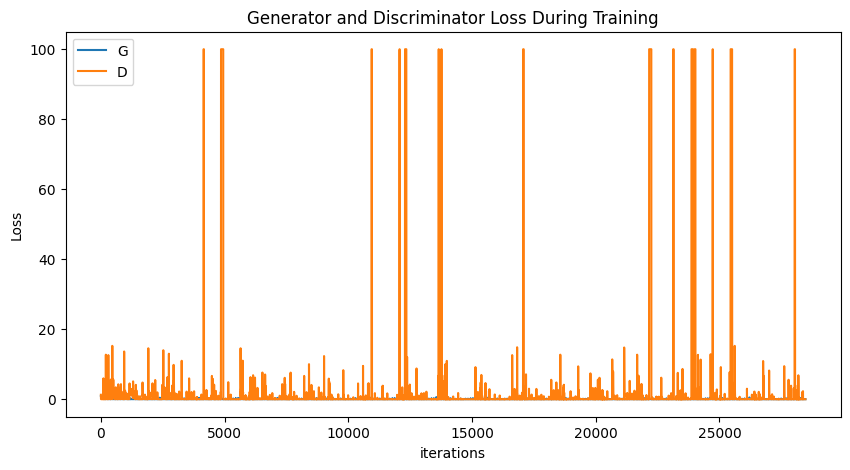

[1/16]


Loss_D: 0.0273	Loss_G: 4.0009 / 0.0146	D(x): 1.0000	D(G(z)): 0.0269 / 0.0183: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


[2/16]


Loss_D: 100.0000	Loss_G: 0.0000 / 0.0087	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


[3/16]


Loss_D: 0.0038	Loss_G: 5.6335 / 0.0139	D(x): 1.0000	D(G(z)): 0.0038 / 0.0036: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


[4/16]


Loss_D: 0.0013	Loss_G: 6.6946 / 0.0101	D(x): 1.0000	D(G(z)): 0.0013 / 0.0012: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


[5/16]


Loss_D: 0.0068	Loss_G: 5.1513 / 0.0089	D(x): 0.9999	D(G(z)): 0.0066 / 0.0058: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


[6/16]


Loss_D: 0.0076	Loss_G: 5.0627 / 0.0083	D(x): 0.9997	D(G(z)): 0.0073 / 0.0063: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


[7/16]


Loss_D: 0.0003	Loss_G: 8.2979 / 0.0100	D(x): 1.0000	D(G(z)): 0.0003 / 0.0002: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


[8/16]


Loss_D: 0.0037	Loss_G: 6.8963 / 0.0137	D(x): 0.9973	D(G(z)): 0.0009 / 0.0010: 100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


[9/16]


Loss_D: 0.0008	Loss_G: 7.1248 / 0.0114	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


[10/16]


Loss_D: 0.0032	Loss_G: 5.8604 / 0.0144	D(x): 0.9999	D(G(z)): 0.0031 / 0.0029: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


[11/16]


Loss_D: 0.0061	Loss_G: 5.1758 / 0.0127	D(x): 0.9998	D(G(z)): 0.0058 / 0.0057: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


[12/16]


Loss_D: 0.0090	Loss_G: 4.7745 / 0.0147	D(x): 1.0000	D(G(z)): 0.0090 / 0.0084: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


[13/16]


Loss_D: 0.0505	Loss_G: 1.4275 / 0.0148	D(x): 1.0000	D(G(z)): 0.0492 / 0.2399: 100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


[14/16]


Loss_D: 0.0093	Loss_G: 4.7486 / 0.0125	D(x): 1.0000	D(G(z)): 0.0093 / 0.0087: 100%|██████████| 82/82 [00:06<00:00, 12.41it/s] 


[15/16]


Loss_D: 0.0059	Loss_G: 5.1774 / 0.0124	D(x): 1.0000	D(G(z)): 0.0059 / 0.0056: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


[16/16]


Loss_D: 0.0022	Loss_G: 6.2474 / 0.0125	D(x): 0.9997	D(G(z)): 0.0020 / 0.0019: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


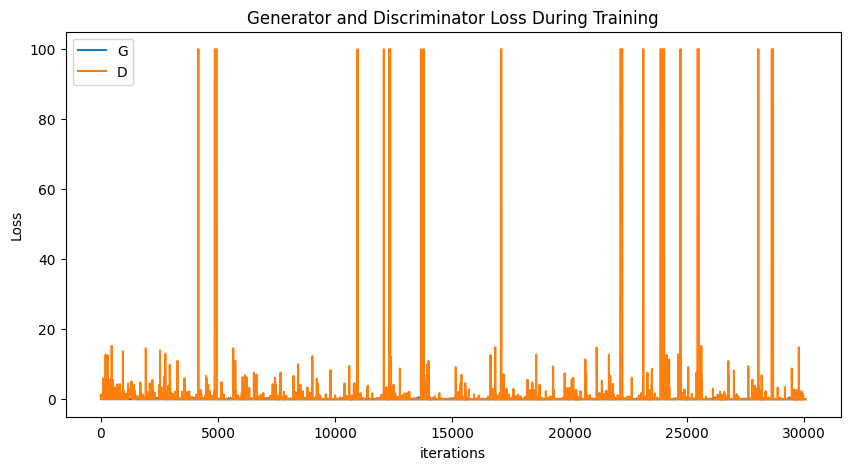

[1/16]


Loss_D: 0.0017	Loss_G: 6.4069 / 0.0143	D(x): 0.9999	D(G(z)): 0.0016 / 0.0017: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


[2/16]


Loss_D: 0.0261	Loss_G: 3.7766 / 0.0095	D(x): 0.9998	D(G(z)): 0.0256 / 0.0229: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


[3/16]


Loss_D: 0.0012	Loss_G: 6.7749 / 0.0152	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


[4/16]


Loss_D: 0.0008	Loss_G: 7.1496 / 0.0096	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008: 100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


[5/16]


Loss_D: 0.0070	Loss_G: 5.0793 / 0.0099	D(x): 0.9998	D(G(z)): 0.0067 / 0.0062: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


[6/16]


Loss_D: 0.0068	Loss_G: 5.1581 / 0.0084	D(x): 0.9990	D(G(z)): 0.0058 / 0.0058: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


[7/16]


Loss_D: 0.0008	Loss_G: 7.1977 / 0.0099	D(x): 1.0000	D(G(z)): 0.0008 / 0.0007: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


[8/16]


Loss_D: 0.0054	Loss_G: 7.7064 / 0.0118	D(x): 0.9950	D(G(z)): 0.0004 / 0.0004: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


[9/16]


Loss_D: 0.0004	Loss_G: 7.9851 / 0.0176	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


[10/16]


Loss_D: 0.0961	Loss_G: 2.7659 / 0.0132	D(x): 0.9770	D(G(z)): 0.0702 / 0.0629: 100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


[11/16]


Loss_D: 0.0012	Loss_G: 7.0112 / 0.0138	D(x): 0.9997	D(G(z)): 0.0009 / 0.0009: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


[12/16]


Loss_D: 0.0381	Loss_G: 3.4037 / 0.0096	D(x): 0.9991	D(G(z)): 0.0365 / 0.0333: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


[13/16]


Loss_D: 0.0151	Loss_G: 3.2067 / 0.0151	D(x): 1.0000	D(G(z)): 0.0150 / 0.0405: 100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


[14/16]


Loss_D: 0.0046	Loss_G: 5.4072 / 0.0115	D(x): 1.0000	D(G(z)): 0.0046 / 0.0045: 100%|██████████| 82/82 [00:06<00:00, 12.34it/s]


[15/16]


Loss_D: 0.0061	Loss_G: 5.1333 / 0.0116	D(x): 1.0000	D(G(z)): 0.0061 / 0.0059: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


[16/16]


Loss_D: 0.0029	Loss_G: 5.9803 / 0.0110	D(x): 0.9997	D(G(z)): 0.0026 / 0.0025: 100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


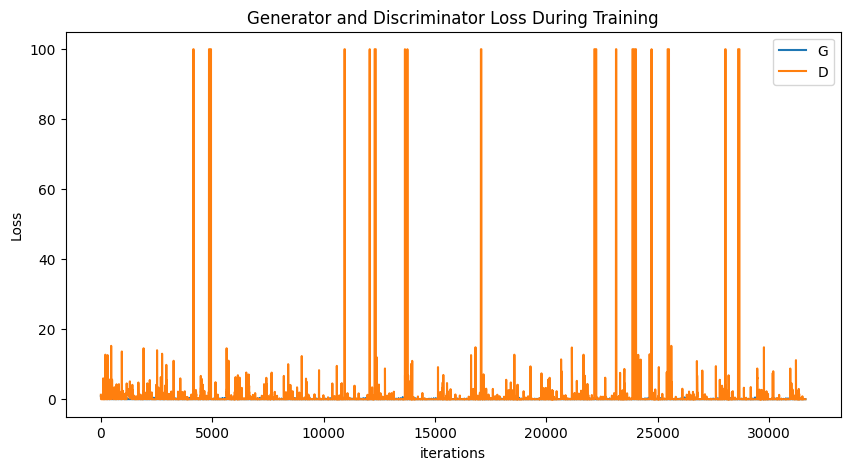

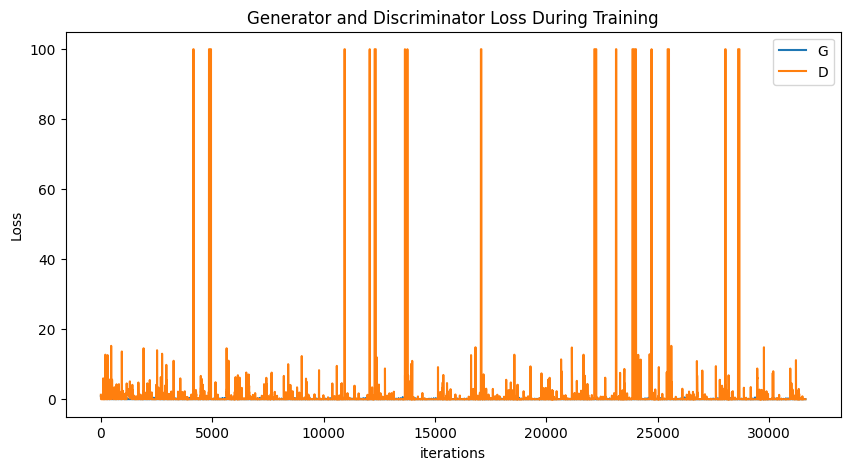

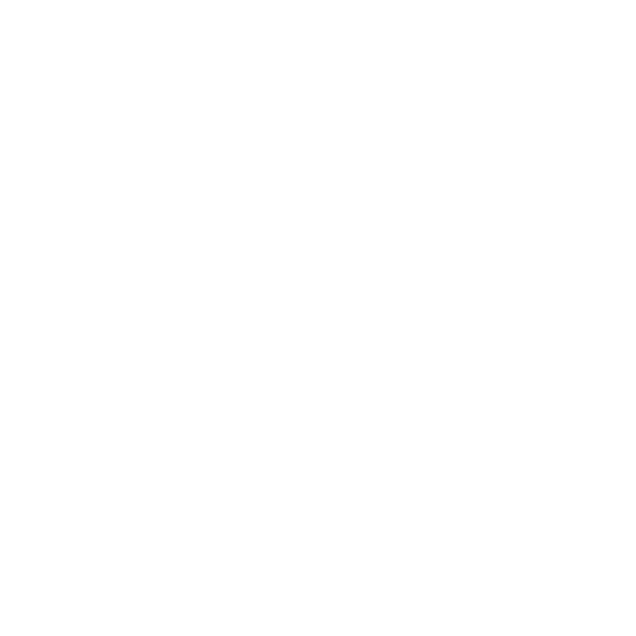

In [45]:
pretrained_path = ""

if pretrained_path != "":
    model.G = torch.load('/kaggle/working/atg.pth')
    model.D = torch.load('/kaggle/working/atd.pth')
    model.setOptimizer()
  

history = train_loop(config, train_loader, params)

In [46]:
print("done - show video here")
# saveVideo(img_list[-1000::5])

done - show video here


In [47]:
# pretrained_path = ""

# if pretrained_path != "":
#   model.G = torch.load('/kaggle/input/astnet-gan-weights/gen_avenue.pth')
#   model.D = torch.load('/kaggle/input/astnet-gan-weights/disc_avenue.pth')

# history = train_loop(config, train_loader, params)

#### Part 3 - inference

In [48]:
import torch

def inference(config, data_loader, model):
    loss_func_mse = nn.MSELoss(reduction='none')

    model.eval()
    psnr_list = []
    ef = config.MODEL.ENCODED_FRAMES
    df = config.MODEL.DECODED_FRAMES
    fp = ef + df
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            print('[{}/{}]'.format(i+1, len(data_loader)))
            psnr_video = []

            vids, video_name = decode_input(input=data, train=False)
            for f in tqdm(range(len(vids) - fp)):
                # buffer
                video = []
                for name in vids[f:f+fp]:
                  reshaped_frame = torch.reshape(read_frame(name[0]), (1, 3, config.MODEL.IMAGE_SIZE[0], config.MODEL.IMAGE_SIZE[1]))
                  video.append(reshaped_frame.to(device=config.GPUS[0]))
                inputs = video[0]
                output = model(inputs)
                target = video[0]

                del video, inputs


            #     # compute PSNR for each frame
                mse_imgs = torch.mean(loss_func_mse((output[0] + 1) / 2, (target[0] + 1) / 2)).item()
                psnr = psnr_park(mse_imgs)
                psnr_video.append(psnr)

                del output, target
            free_gpu_cache()

            psnr_list.append(psnr_video)
    return psnr_list
        

In [49]:
# inference(config, train_loader, astnet)

### testing

In [50]:
if not os.path.exists('results'):
  os.mkdir('results')

psnr_list = inference(config, test_loader, model.G)
assert len(psnr_list) == len(mat), f'Ground truth has {len(mat)} videos, BUT got {len(psnr_list)} detected videos!'


[1/10]


100%|██████████| 298/298 [00:13<00:00, 21.78it/s]


[2/10]


100%|██████████| 264/264 [00:12<00:00, 20.90it/s]


[3/10]


100%|██████████| 294/294 [00:14<00:00, 20.26it/s]


[4/10]


100%|██████████| 201/201 [00:11<00:00, 18.07it/s]


[5/10]


100%|██████████| 133/133 [00:05<00:00, 25.45it/s]


[6/10]


100%|██████████| 125/125 [00:03<00:00, 41.53it/s]


[7/10]


100%|██████████| 482/482 [00:23<00:00, 20.47it/s]


[8/10]


100%|██████████| 189/189 [00:08<00:00, 21.64it/s]


[9/10]


100%|██████████| 204/204 [00:09<00:00, 20.56it/s]


[10/10]


100%|██████████| 186/186 [00:09<00:00, 20.05it/s]


In [51]:
auc, fpr, tpr = calculate_auc(config, psnr_list, mat)
# breakpoint()
logger.info(f'AUC: {auc * 100:.1f}%' )
np.save('results/fpr_list.npy', fpr)  
np.save('results/tpr_list.npy', tpr)
print(auc)

0.6544115586479681


/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([]

#### AUROC Score

In [52]:
fpr = np.load('results/fpr_list.npy')
tpr = np.load('results/tpr_list.npy')
print(fpr.shape)
print(tpr.shape)

(840,)
(840,)


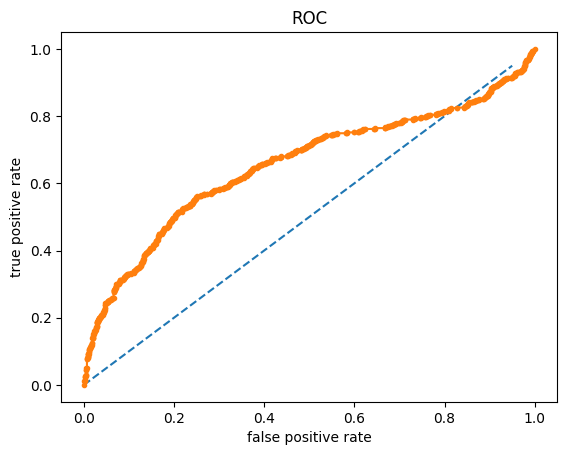

In [53]:
no_skill = []
for i in np.arange(0, 1, 0.05):
  no_skill.append(i)

plt.plot(no_skill, no_skill, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

# giving a title to my graph
plt.title('ROC')
# function to show the plot
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix, auc

aucx = auc(fpr, tpr)
print('aucroc score for ucsd peds - %0.5f'%(aucx)) 

aucroc score for ucsd peds - 0.65441


In [55]:
from scipy.interpolate import make_interp_spline
def score_comparison_graph(psnr, mat):
    plt.figure(figsize=(20,5))
    assert len(psnr) == len(mat), f'Ground truth has {len(mat)} frames, BUT got {len(psnr)} frames!'
    len_video = len(mat)
    plt.xlim(0, len_video)
    for i in range(len(mat)):
        if mat[i] == 1:
            plt.axvspan(i, i+1, facecolor='b', alpha=0.5)
    plt.xlabel('frame')
    plt.ylabel('psnr')
    x = np.arange(len_video)
    y = psnr
    X_Y_Spline = make_interp_spline(x, y)
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(x.min(), x.max(), 100)
    Y_ = X_Y_Spline(X_)
    plt.plot(X_, Y_)
    plt.show()

In [63]:
cd working

/kaggle/working


In [59]:
# import sys,os
# import pathlib
# from pathlib import Path
# files_to_delete = './*' # this considers only ".txt" files. If you want to delete all files, use "./*"
# files_list = pathlib.Path(os.getcwd()).glob(files_to_delete)
# for file_path in files_list:
#     os.remove(file_path)

video [1/10]


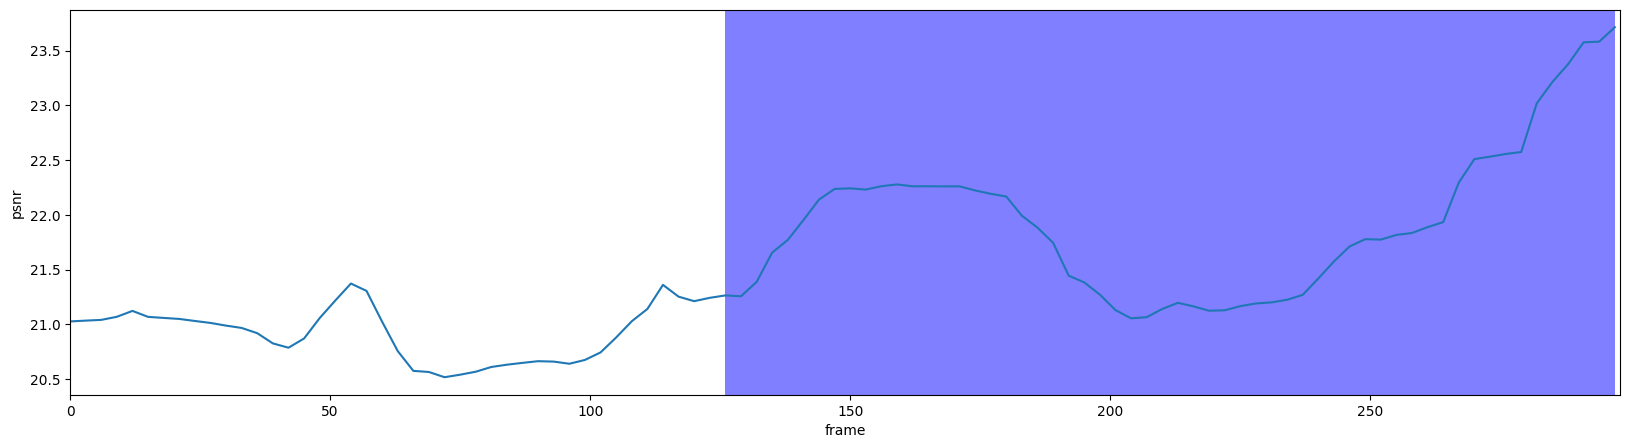

video [1/10]


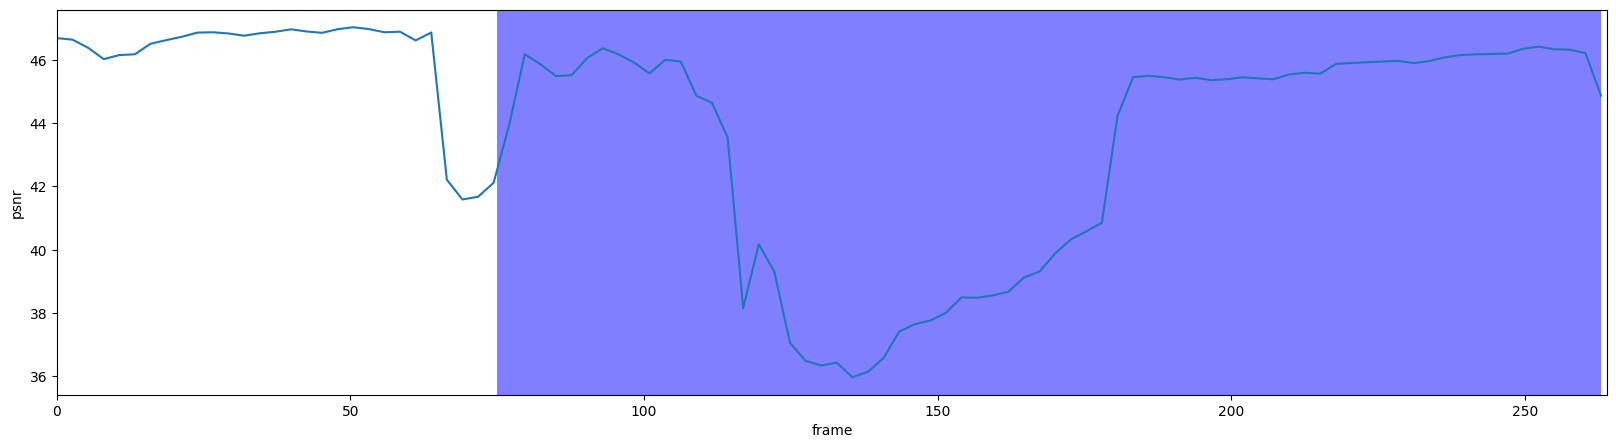

video [1/10]


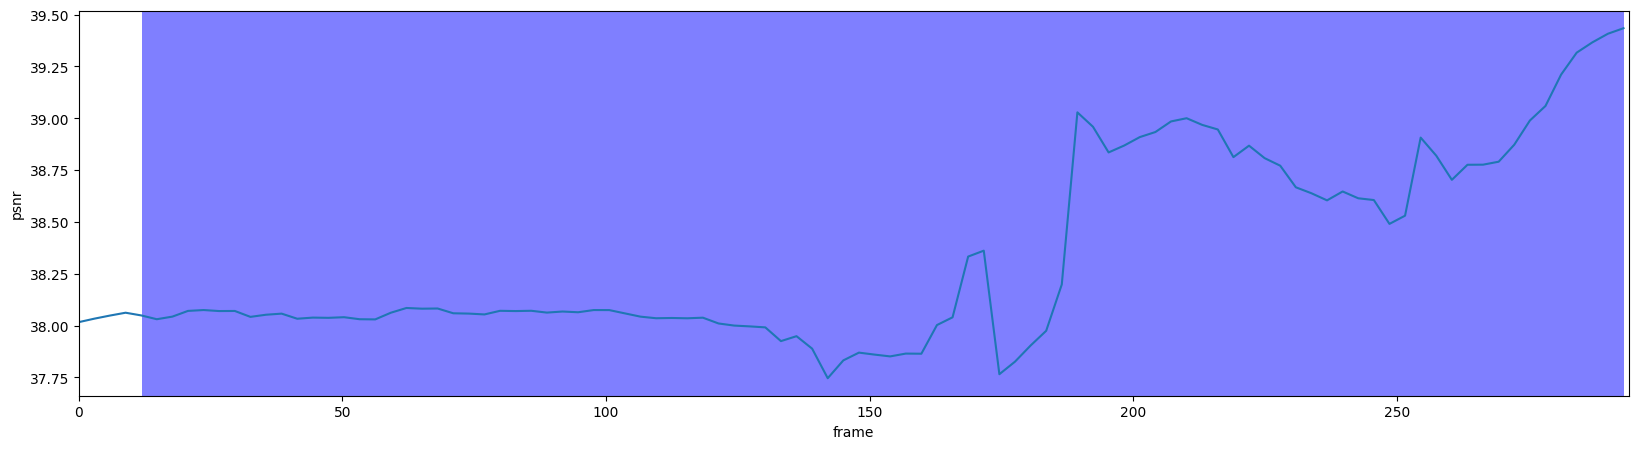

video [1/10]


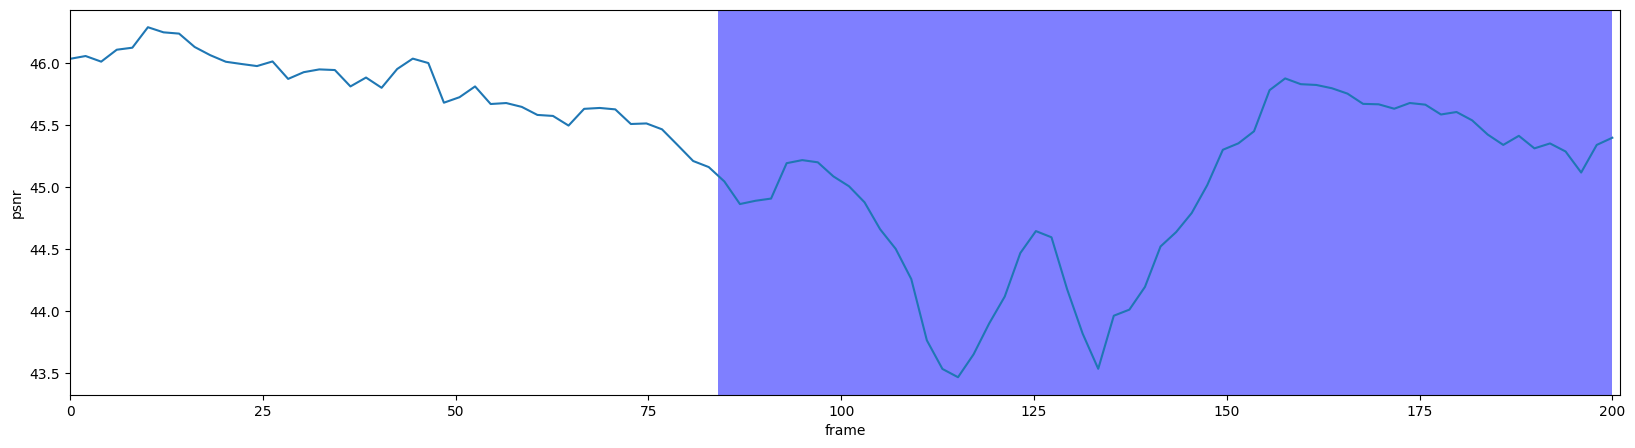

video [1/10]


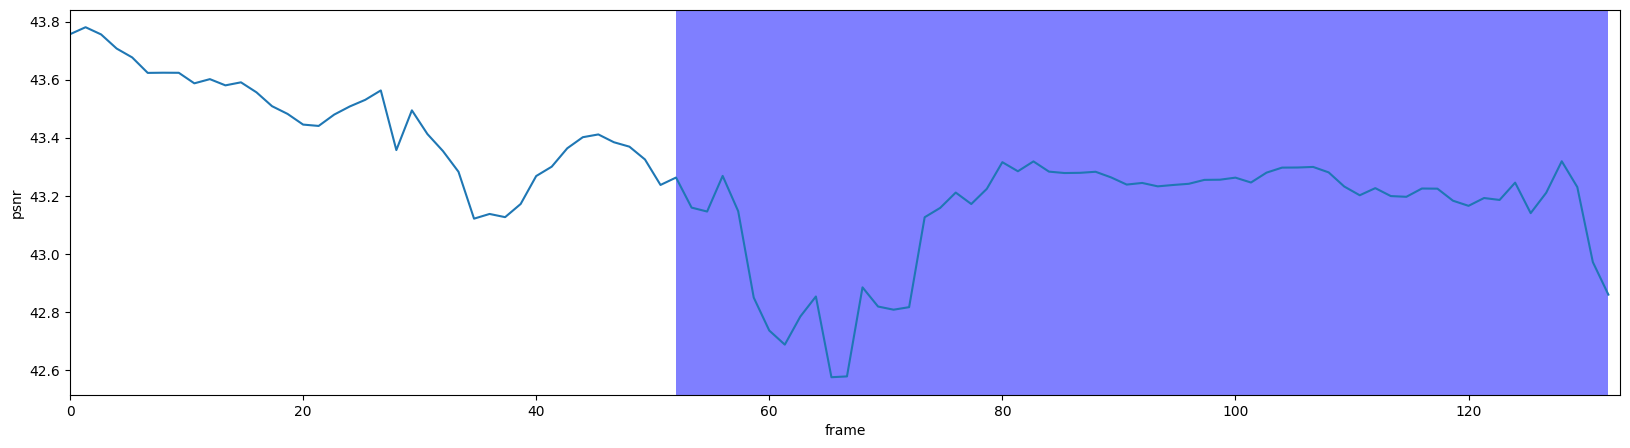

video [1/10]


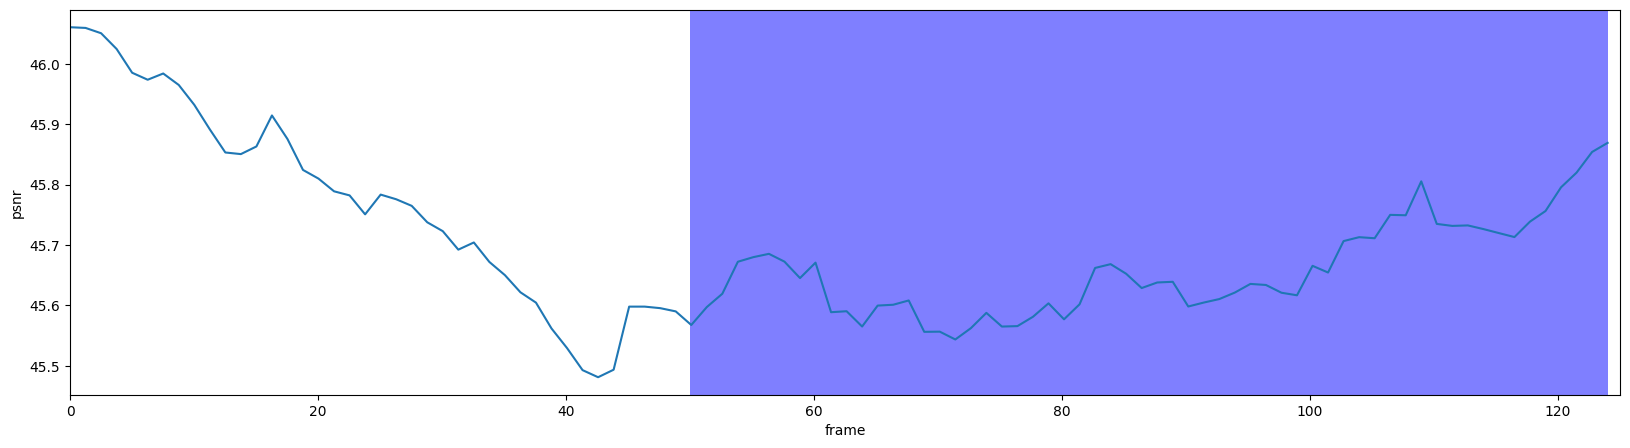

video [1/10]


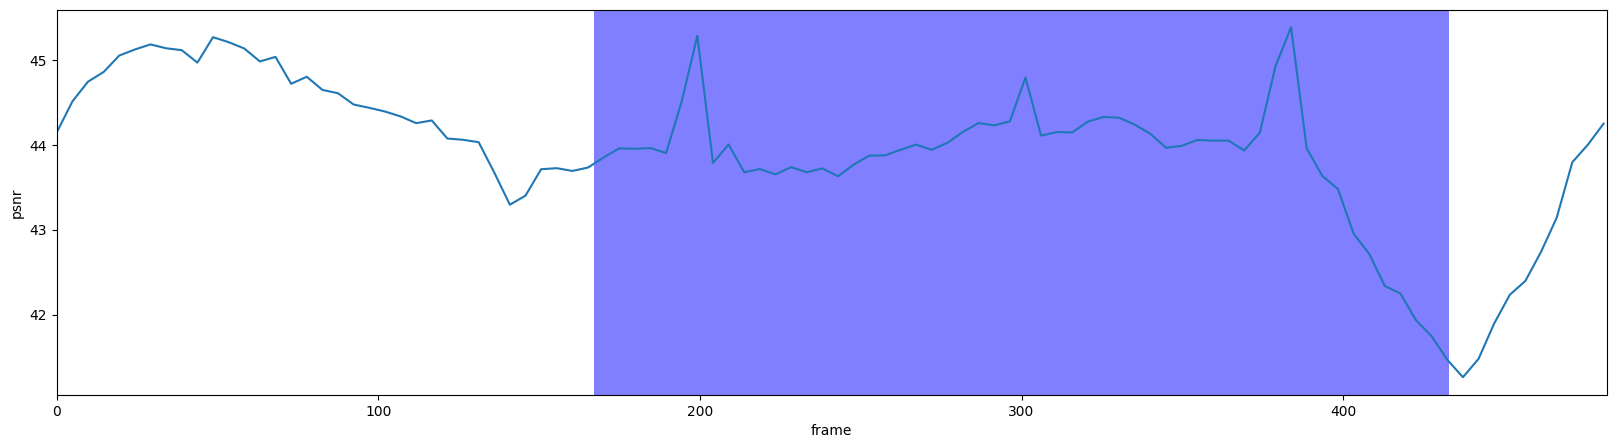

video [1/10]


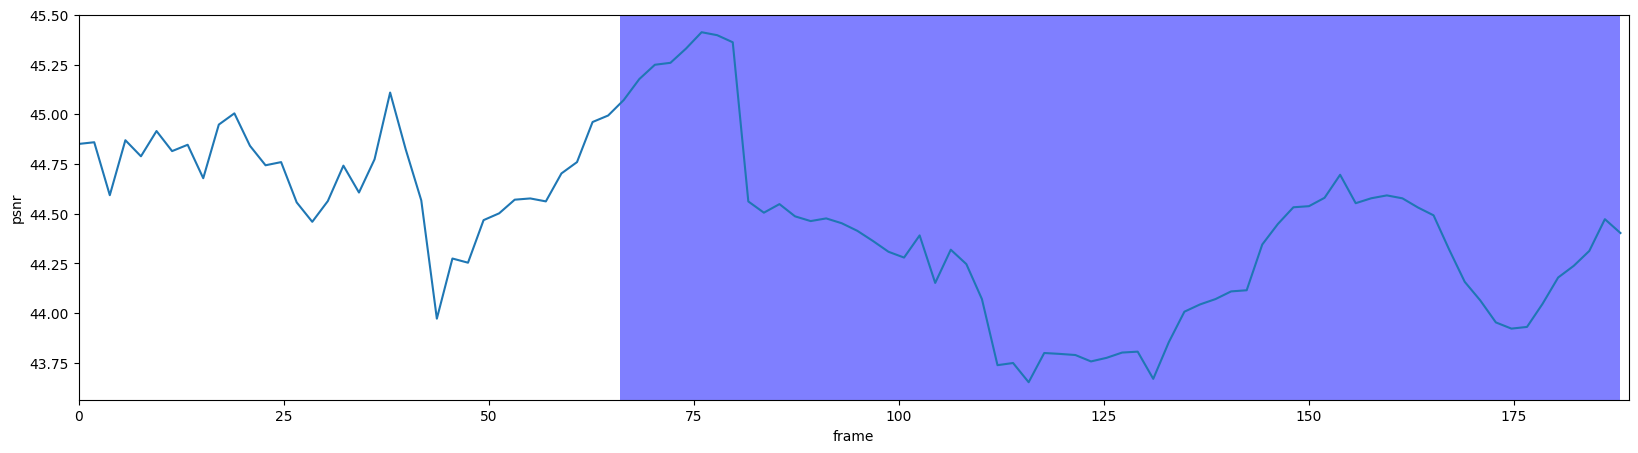

video [1/10]


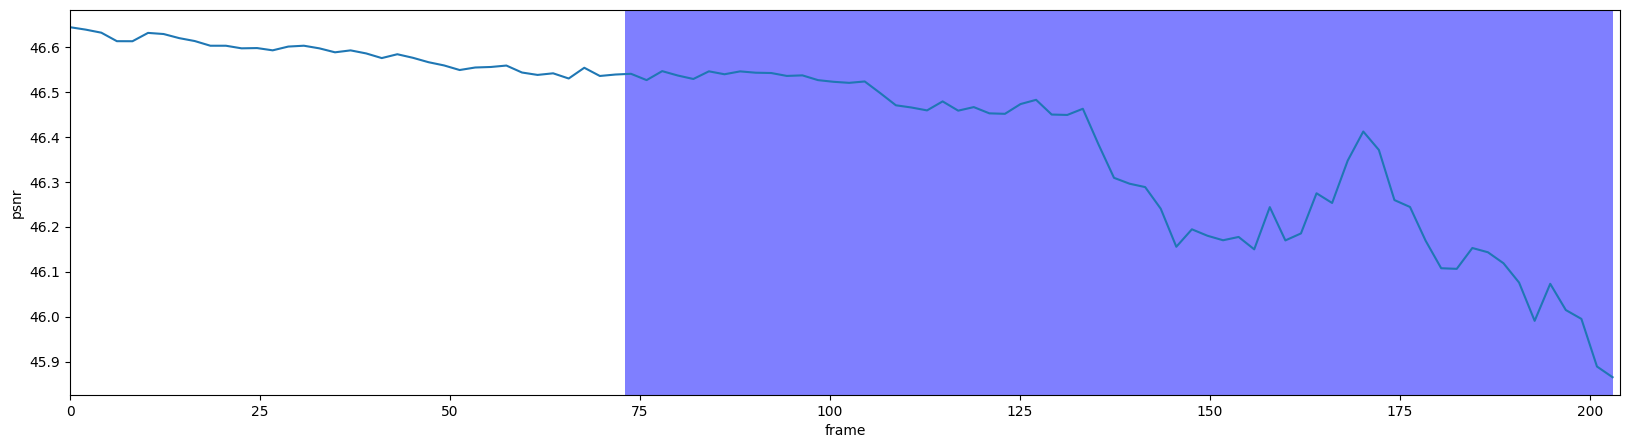

video [1/10]


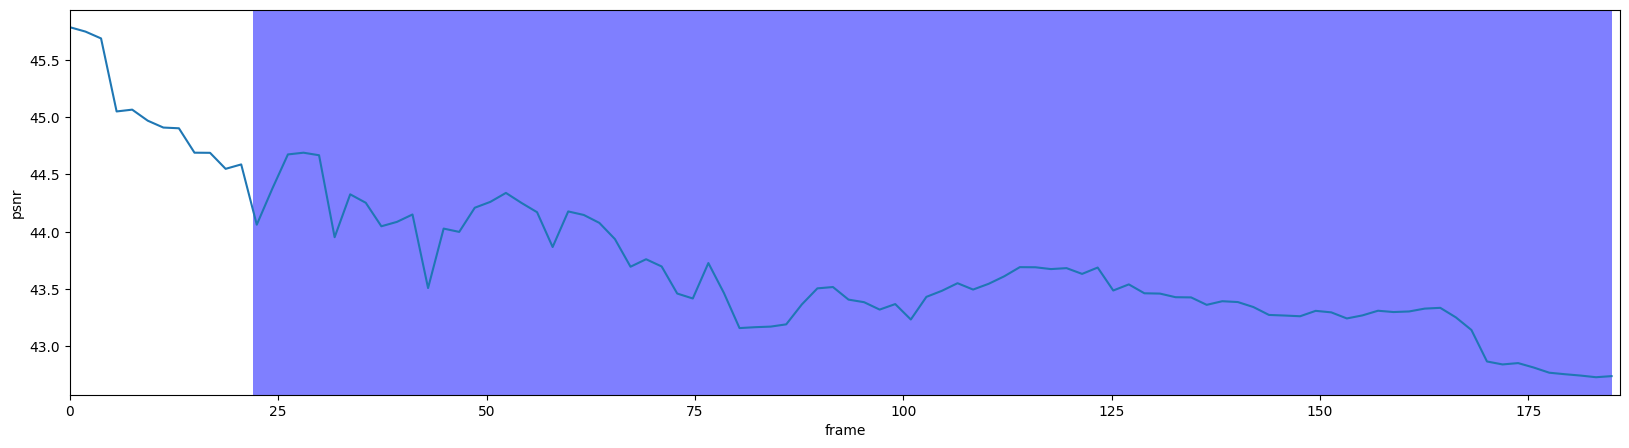

In [64]:
index = 0
for (psnr, labels) in zip(psnr_list, mat):
    index=+1
    ef = config.MODEL.ENCODED_FRAMES
    df = config.MODEL.DECODED_FRAMES
    fp = ef + df  # number of frames to process
    labels = labels[fp:]
    print("video [{}/{}]".format(index, len(mat)))
    score_comparison_graph(psnr, labels)

In [65]:
def test_all(path1):
    epochs = []
    for fname in os.listdir(path1):
        if len(fname.split('_')) >= 2:
            s1 = fname.split('_')[1]
            f1 = s1.split('.')[0]
            epochs.append(f1)
    for eph in epochs:
        netG = torch.load(f'model/generator_{eph}.pth')
        try:
            psnr_list = inference(config, test_loader, netG)
            assert len(psnr_list) == len(mat), f'Ground truth has {len(mat)} videos, but got {len(psnr_list)} detected videos'
            auc, fpr, tpr = calculate_auc(config, psnr_list, mat)
            print(f'file={eph}')
            print(f'auc={auc}')
        except:
            print('error')

In [66]:
test_all('model')

[1/10]


100%|██████████| 298/298 [00:11<00:00, 25.56it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 24.59it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 23.99it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 21.58it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.02it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 48.04it/s]


[7/10]


100%|██████████| 482/482 [00:20<00:00, 23.68it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.23it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.69it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 24.40it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=16
auc=0.744354990451865
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.70it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.61it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.47it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.34it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.53it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.56it/s]


[7/10]


100%|██████████| 482/482 [00:20<00:00, 24.09it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.17it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.48it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.02it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=1
auc=0.6489184785437192
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.92it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.52it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.50it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.44it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.81it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.63it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.46it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.95it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.95it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.03it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=10
auc=0.6491278569341079
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.81it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.50it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.54it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.44it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.65it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 52.10it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.39it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.18it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.15it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.16it/s]


file=9
auc=0.632142985823922


/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([]

[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.67it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.54it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.50it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.53it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.03it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.58it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.49it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.09it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.34it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.23it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=18
auc=0.6473323271427256
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.68it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.11it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.32it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.20it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.62it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.08it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.47it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.27it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.04it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.06it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=15
auc=0.6795481750451384
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.59it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.31it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.62it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.31it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.72it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.95it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.53it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.32it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.16it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.24it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=17
auc=0.6519362496847314
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.62it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.66it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.70it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.20it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.59it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 49.40it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.39it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.14it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.11it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.47it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=5
auc=0.5685059670839555
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.89it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.50it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.75it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.37it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.99it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.29it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.37it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.37it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.10it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.53it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=6
auc=0.62063478083327
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.77it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.52it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.94it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.22it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.94it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.28it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.40it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.98it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.01it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.10it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=3
auc=0.6379086982108757
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.65it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.60it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.61it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.15it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.77it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.48it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.69it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.92it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.11it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.37it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=8
auc=0.6215227373722412
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.45it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.54it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.48it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.18it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.55it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 49.57it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.58it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.89it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.26it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.15it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=13
auc=0.6393479244316157
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.51it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.25it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.76it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.41it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.47it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.83it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.65it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.08it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.29it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.08it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=2
auc=0.6104140727900171
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.67it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.43it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.67it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.46it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 31.47it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.72it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.58it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.91it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.85it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.13it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=15
auc=0.6795481750451384
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.64it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.25it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.76it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.38it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.82it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.04it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.53it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.73it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.00it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.30it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=14
auc=0.6354225800381926
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.88it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.47it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.67it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.31it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.49it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.06it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.44it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.34it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.09it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.33it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=12
auc=0.6393943639981263
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.96it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.43it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.66it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.47it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.22it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 49.24it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.53it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.29it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.91it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.32it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=8
auc=0.6215227373722412
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.81it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.51it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.63it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.42it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.07it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.12it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.48it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.45it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.12it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.30it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=7
auc=0.6296732816359538
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.85it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.44it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.72it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.43it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.17it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.29it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.44it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.43it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.03it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.32it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=5
auc=0.5685059670839555
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.88it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.53it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.46it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.51it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.70it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.93it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.48it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.21it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.20it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.07it/s]


file=12
auc=0.6393943639981263


/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([]

[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.87it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.35it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.41it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.58it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.07it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.23it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.43it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.14it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.11it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 24.81it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=18
auc=0.6473323271427256
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.81it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.65it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.53it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.50it/s]


[5/10]


100%|██████████| 133/133 [00:03<00:00, 33.32it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.84it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.52it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.28it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.99it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 24.91it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=9
auc=0.632142985823922
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.81it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.58it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.43it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.43it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.20it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.99it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.22it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.10it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.91it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 24.90it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=1
auc=0.6489184785437192
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.51it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.19it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.24it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.32it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.60it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 49.46it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.23it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.22it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.78it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 24.56it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=0
auc=0.6495245949549016
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.57it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.52it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.53it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.45it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.71it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.21it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.21it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.15it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.11it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.12it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=6
auc=0.62063478083327
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.82it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.46it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.25it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.01it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.82it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.16it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.31it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.11it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.00it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.00it/s]


file=16
auc=0.744354990451865


/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([]

[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.48it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.53it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.52it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.33it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.15it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.77it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.39it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.94it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.05it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.36it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=7
auc=0.6296732816359538
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.80it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.28it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.79it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.53it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.17it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.49it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.53it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.15it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.26it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.30it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=19
auc=0.6544115586479681
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.35it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.76it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.65it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.40it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.20it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 48.40it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.45it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.28it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.07it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.06it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=4
auc=0.6361131684194935
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.61it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.62it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.71it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.16it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.96it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.87it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.59it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.07it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.92it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.33it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=11
auc=0.6675279337995973
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.39it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.54it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.70it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 21.96it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.31it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.94it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.15it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.29it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.20it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.41it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=14
auc=0.6354225800381926
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.62it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.68it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.90it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.12it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.08it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.49it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.28it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.25it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.10it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.08it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=2
auc=0.6104140727900171
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.56it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.75it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.92it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.01it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.04it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.05it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.67it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.10it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.10it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.24it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=4
auc=0.6361131684194935
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.72it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.54it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.44it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.08it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.95it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.39it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.61it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.25it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.30it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.39it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=19
auc=0.6544115586479681
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.85it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.56it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.78it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.41it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.13it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 52.14it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.56it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.15it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.33it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.36it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=3
auc=0.6379086982108757
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.86it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.53it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.88it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.44it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.59it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.72it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.65it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 25.96it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.34it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.04it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=17
auc=0.6519362496847314
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.73it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.55it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.93it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.64it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.83it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 51.19it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.37it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.48it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.92it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.04it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=10
auc=0.6491278569341079
[1/10]


100%|██████████| 298/298 [00:11<00:00, 27.04it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.52it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.66it/s]


[4/10]


100%|██████████| 201/201 [00:08<00:00, 22.69it/s]


[5/10]


100%|██████████| 133/133 [00:03<00:00, 33.41it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 48.00it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.50it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.13it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.02it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.22it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=11
auc=0.6675279337995973
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.75it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 24.97it/s]


[3/10]


100%|██████████| 294/294 [00:11<00:00, 24.65it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.33it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 33.18it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.80it/s]


[7/10]


100%|██████████| 482/482 [00:20<00:00, 23.88it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.27it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 25.00it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 25.04it/s]
/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

file=0
auc=0.6495245949549016
[1/10]


100%|██████████| 298/298 [00:11<00:00, 26.88it/s]


[2/10]


100%|██████████| 264/264 [00:10<00:00, 25.14it/s]


[3/10]


100%|██████████| 294/294 [00:12<00:00, 24.38it/s]


[4/10]


100%|██████████| 201/201 [00:09<00:00, 22.24it/s]


[5/10]


100%|██████████| 133/133 [00:04<00:00, 32.76it/s]


[6/10]


100%|██████████| 125/125 [00:02<00:00, 50.37it/s]


[7/10]


100%|██████████| 482/482 [00:19<00:00, 24.28it/s]


[8/10]


100%|██████████| 189/189 [00:07<00:00, 26.22it/s]


[9/10]


100%|██████████| 204/204 [00:08<00:00, 24.62it/s]


[10/10]


100%|██████████| 186/186 [00:07<00:00, 24.97it/s]

file=13
auc=0.6393479244316157



/tmp/ipykernel_32/3349791007.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.array([], dtype=np.float)
/tmp/ipykernel_32/3349791007.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([

In [ ]:
ls results

In [ ]:
ls model